In [1]:
import csv
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from PIL import Image

# import keras

from pymongo import MongoClient

from ajna_commons.conf import ENCODE
from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from ajna_commons.utils.images import get_imagens_recortadas

In [2]:
sys.path.insert(0, '../../virasana/')
# from virasana.integracao import carga, CHAVES_GRIDFS
# from virasana.exportacao.utils import campos_mongo_para_lista

ENCONTRADOS = {'metadata.carga.atracacao.escala': {'$ne': None},
               'metadata.contentType': 'image/jpeg'}


In [3]:
def get_lista(db, start, end):
    
    filtro = ENCONTRADOS
    filtro['metadata.predictions.bbox'] = {'$exists': True, '$ne': None}
    filtro['metadata.dataescaneamento'] = {
        '$gt': datetime.strptime(start, '%Y-%m-%d'),
        '$lt': datetime.strptime(end, '%Y-%m-%d')
    }
    filtro['metadata.carga.vazio'] = False
    return db['fs.files'].find(filtro)
    # chaves = ['_id'] + CHAVES_GRIDFS + carga.CHAVES_CARGA
    # return campos_mongo_para_lista(db, filtro, chaves, batch_size)

def get_images(db, lista):
    imagens = []
    for linha in lista:
        _id = linha['_id']
        imagens.append([im for im in get_imagens_recortadas(db, _id)])
    return imagens



In [10]:
db = MongoClient(host=MONGODB_URI)[DATABASE]

cursor = get_lista(db, '2017-07-01', '2017-07-15')
lista = [linha for linha in cursor]

In [11]:
linha = lista[1]
print(linha)


{'_id': ObjectId('5aa1a0622a87954aafdd9fec'), 'md5': '1f415b10ba5d7de23611325dae253bb0', 'uploadDate': datetime.datetime(2018, 3, 8, 20, 43, 14, 747000), 'filename': '20170702002614001KS_stamp.jpg', 'length': 18245, 'chunkSize': 261120, 'metadata': {'carga': {'manifesto': [{'_id': ObjectId('5aa834122a879534fffbcfe4'), 'manifesto': '1517501387740', 'nomeempresanavegacao': 'hamburg sudamerikanische', 'nomeportodescarregamento': 'santos', 'dataemissao': '21/06/2017', 'nometerminaldescarregamento1': 'santos brasil', 'codigoportocarregamento': 'ushou', 'codigoterminaldescarregamento1': 'brssz016', 'codigoempresanavegacao': 'de001046', 'codigoportodescarregamento': 'brssz', 'codigoagencianavegacao': '02427026000146', 'nomeportocarregamento': 'houston', 'tipomanifesto': 'lci', 'nomeagencianavegacao': 'alianca navegacao e logistica ltda.'}], 'conhecimento': [{'_id': ObjectId('5aa833d62a879534fffa2f00'), 'codigosituacao': '07', 'nomeraarmazenamento': 'inst. portuaria publica - santos brasil par

In [12]:
print(len(lista))

2979


In [13]:
images = get_images(db, lista)
print(len(images))

2979


[1102  779 1230 1275 2766  656 2020 2492 2802  315  624 2815 1547 1351
 1056 2905  763 1040 2036  458  908 1053  585 1311  836 2695   53 1711
  244 2156 1254 2254  202 1045 1875 2334  513 1554 1377  768 1613]


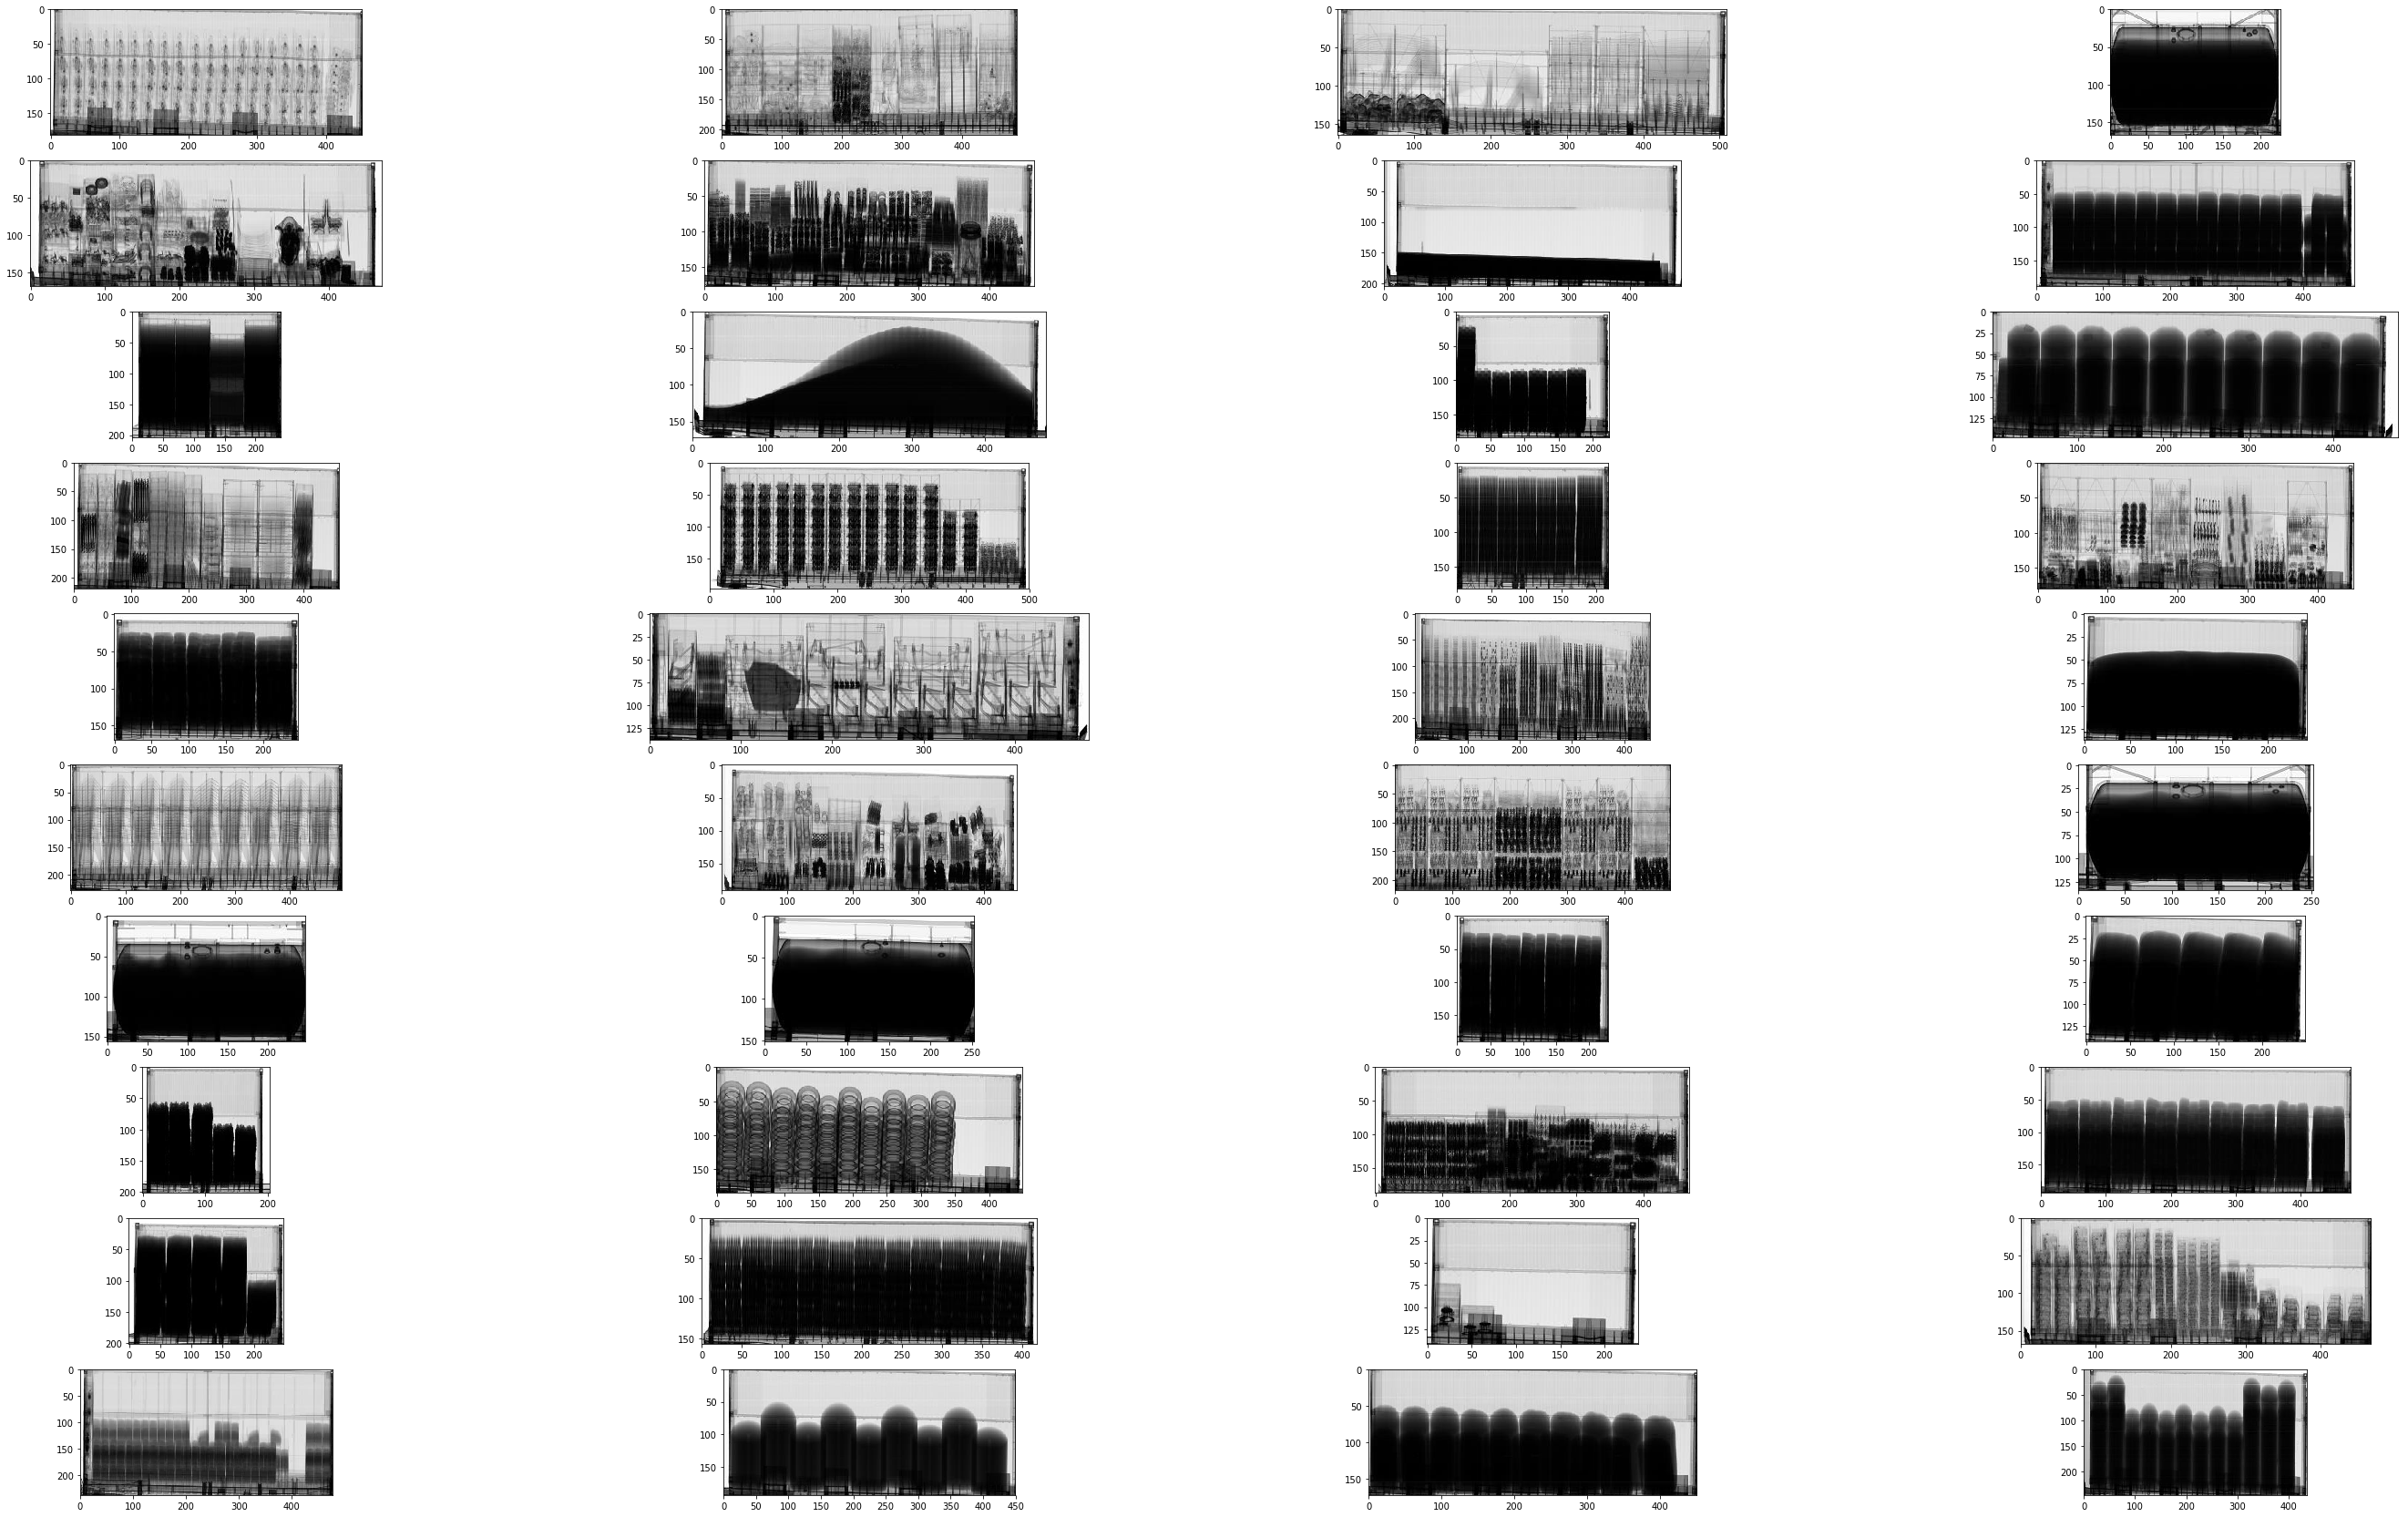

In [14]:
%matplotlib inline

    
fig=plt.figure(figsize=(50, 30))
columns = 4
rows = 10

indexes = np.random.randint(len(images) - 1, size=columns*rows + 1)
print(indexes)
random_images = [images[index][0] for index in indexes]
for i in range(1, columns*rows +1):
    img = random_images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


In [104]:
histograms = [np.histogram(np.asarray(image[0]), bins=8, density=True)[0] for image in images]
histograms
    

[array([0.00911403, 0.00158909, 0.00094787, 0.00088019, 0.00097033,
        0.00207474, 0.01399389, 0.0018024 ]),
 array([0.01176255, 0.00255982, 0.00113582, 0.00053576, 0.00046663,
        0.00132995, 0.01121634, 0.00236569]),
 array([0.01573405, 0.00296348, 0.00173217, 0.00111931, 0.00089986,
        0.00110251, 0.00618211, 0.00163907]),
 array([0.00158971, 0.00334104, 0.00464524, 0.00559254, 0.00520658,
        0.00424296, 0.0059479 , 0.00080658]),
 array([0.01181432, 0.00277823, 0.00144464, 0.00071958, 0.00073393,
        0.00158484, 0.01027762, 0.00201938]),
 array([0.00161344, 0.00332468, 0.00475738, 0.00550633, 0.00521707,
        0.00400472, 0.00583521, 0.00111373]),
 array([0.00360005, 0.00376047, 0.00317457, 0.00193929, 0.00117258,
        0.00179656, 0.01272521, 0.00320381]),
 array([0.00945172, 0.00278039, 0.00140453, 0.00095464, 0.00081867,
        0.00169641, 0.01229084, 0.00197536]),
 array([0.01545773, 0.00383812, 0.00168838, 0.00099453, 0.00060695,
        0.00100535, 

In [16]:
pesos = []
for linha in lista:
    carga = linha.get('metadata').get('carga')
    #print(carga)
    if carga:
        vazio = carga.get('vazio')
        # print(vazio)
        if vazio is False:
            container = carga.get('container')
            if container:
                tara = float(container[0].get('taracontainer').replace(',', '.'))
                peso = float(container[0].get('pesobrutoitem').replace(',', '.'))
                pesos.append(tara + peso)
# print(pesos)



In [105]:
df = pd.DataFrame(histograms)
print(np.histogram(np.asarray(images[0][0]), bins=8, density=True)[1])
df.columns = np.histogram(np.asarray(images[0][0]), bins=8, density=True)[1][1:]
df['peso'] = pesos
print(len(pesos))
print(len(df))
df

[  0.     31.875  63.75   95.625 127.5   159.375 191.25  223.125 255.   ]
2979
2979


31.875     63.75    95.625     127.5   159.375    191.25   223.125  \
0     0.009114  0.001589  0.000948  0.000880  0.000970  0.002075  0.013994   
1     0.011763  0.002560  0.001136  0.000536  0.000467  0.001330  0.011216   
2     0.015734  0.002963  0.001732  0.001119  0.000900  0.001103  0.006182   
3     0.001590  0.003341  0.004645  0.005593  0.005207  0.004243  0.005948   
4     0.011814  0.002778  0.001445  0.000720  0.000734  0.001585  0.010278   
5     0.001613  0.003325  0.004757  0.005506  0.005217  0.004005  0.005835   
6     0.003600  0.003760  0.003175  0.001939  0.001173  0.001797  0.012725   
7     0.009452  0.002780  0.001405  0.000955  0.000819  0.001696  0.012291   
8     0.015458  0.003838  0.001688  0.000995  0.000607  0.001005  0.006895   
9     0.002924  0.016096  0.003288  0.002247  0.001340  0.001598  0.003186   
10    0.002082  0.017174  0.003587  0.002339  0.001425  0.001590  0.002244   
11    0.011927  0.002667  0.001435  0.000621  0.000687  0.001581  0.010632   
12    0.011492  0.003195  0.001614  0.001189  0.000766  0.001278  0.009765   
13    0.009159  0.001754  0.000827  0.000591  0.000588  0.001797  0.012462   
14    0.015873  0.003348  0.001531  0.000819  0.000585  0.001117  0.007313   
15    0.019815  0.001530  0.000961  0.000726  0.000496  0.001074  0.004234   
16    0.020751  0.001822  0.001100  0.000820  0.000713  0.001618  0.002526   
17    0.019047  0.001779  0.001100  0.000887  0.000755  0.001351  0.003792   
18    0.021196  0.001959  0.001265  0.000822  0.000638  0.001511  0.002662   
19    0.019652  0.001737  0.000842  0.000643  0.000484  0.001079  0.004309   
20    0.019287  0.002073  0.001177  0.000955  0.000648  0.001281  0.003986   
21    0.020758  0.001740  0.001047  0.000760  0.000595  0.001518  0.002640   
22    0.020408  0.002105  0.001318  0.000946  0.000821  0.001606  0.002648   
23    0.020330  0.001708  0.000996  0.000622  0.000432  0.001204  0.004359   
24    0.015054  0.003948  0.001442  0.001032  0.000846  0.001108  0.004789   
25    0.019583  0.002459  0.001526  0.000917  0.000624  0.001299  0.003245   
26    0.020029  0.001657  0.001059  0.000745  0.000518  0.001221  0.004079   
27    0.020527  0.001494  0.000994  0.000748  0.000579  0.001244  0.004073   
28    0.015785  0.003270  0.001578  0.000974  0.000803  0.001153  0.006533   
29    0.003554  0.006054  0.003107  0.001657  0.001131  0.002177  0.012156   
...        ...       ...       ...       ...       ...       ...       ...   
2949  0.005240  0.001834  0.003754  0.002720  0.002279  0.002226  0.009603   
2950  0.001330  0.003539  0.005592  0.006557  0.006040  0.003186  0.002983   
2951  0.012981  0.003272  0.002190  0.001686  0.001311  0.001899  0.005701   
2952  0.004908  0.003776  0.002230  0.001742  0.001510  0.001271  0.011931   
2953  0.012919  0.002194  0.001450  0.001069  0.000791  0.001497  0.009582   
2954  0.010033  0.001725  0.001291  0.000980  0.000914  0.001112  0.009851   
2955  0.011300  0.001899  0.001181  0.000909  0.000877  0.001630  0.009644   
2956  0.016918  0.002830  0.001633  0.001380  0.001164  0.001750  0.004814   
2957  0.000813  0.001659  0.007502  0.010288  0.004212  0.003005  0.003260   
2958  0.005174  0.004431  0.003596  0.002683  0.002059  0.002952  0.008350   
2959  0.000993  0.000982  0.004404  0.011542  0.003959  0.003282  0.005148   
2960  0.001001  0.004339  0.007173  0.007524  0.004232  0.002771  0.003226   
2961  0.001098  0.001159  0.003653  0.013738  0.003126  0.003515  0.004408   
2962  0.001030  0.001076  0.004834  0.008128  0.003669  0.003350  0.008058   
2963  0.004659  0.004548  0.003365  0.002954  0.002969  0.002731  0.008256   
2964  0.019335  0.001892  0.001387  0.000969  0.000717  0.001361  0.004242   
2965  0.013333  0.002035  0.001262  0.000567  0.000779  0.002172  0.007882   
2966  0.017768  0.003085  0.001859  0.001332  0.000911  0.001493  0.002897   
2967  0.012149  0.003715  0.002858  0.002460  0.002022  0.001857  0.005494   
2968  0.020538  0.001910  0.00

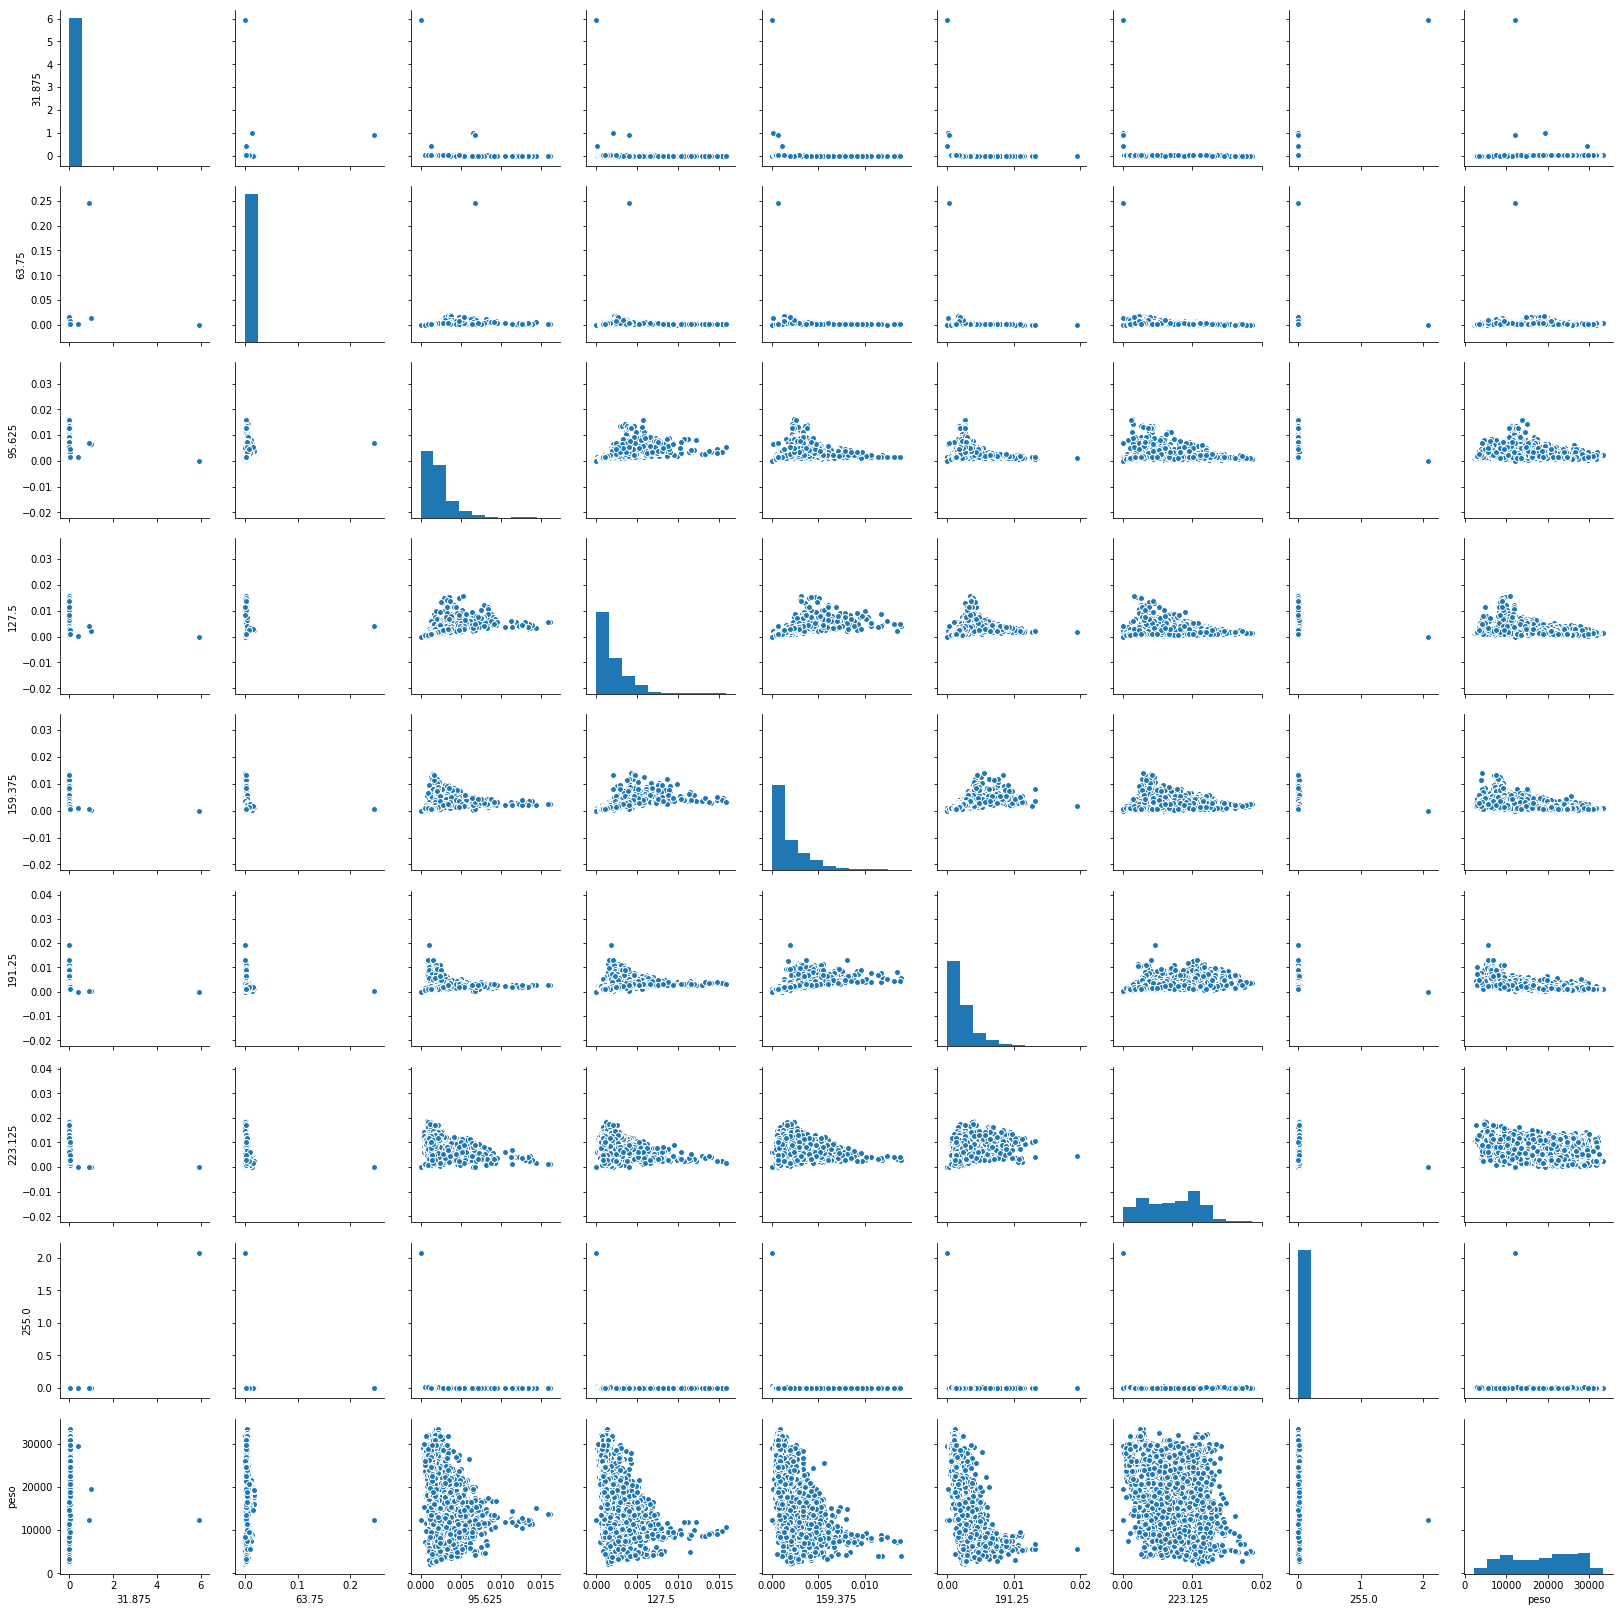

In [34]:
sns.pairplot(df)

In [36]:
for i in range(8):
    print(i, np.corrcoef(df[df.columns[i]], df['peso']))

0 [[1.         0.03448525]
 [0.03448525 1.        ]]
1 [[ 1.         -0.01827039]
 [-0.01827039  1.        ]]
2 [[ 1.         -0.36771119]
 [-0.36771119  1.        ]]
3 [[ 1.         -0.52817661]
 [-0.52817661  1.        ]]
4 [[ 1.         -0.61141842]
 [-0.61141842  1.        ]]
5 [[ 1.         -0.64893655]
 [-0.64893655  1.        ]]
6 [[ 1.         -0.37028349]
 [-0.37028349  1.        ]]
7 [[ 1.         -0.01905969]
 [-0.01905969  1.        ]]


In [39]:
histograms16 = [np.histogram(np.asarray(image[0]), bins=16, density=True)[0] for image in images]
titulo16 = np.histogram(np.asarray(images[0][0]), bins=16, density=True)[1]
df16 = pd.DataFrame(histograms16)
df16.columns = titulo16[1:]
df16['peso'] = pesos

In [41]:

df16

15.9375    31.875   47.8125     63.75   79.6875    95.625  111.5625  \
0     0.015136  0.003092  0.001928  0.001250  0.000921  0.000975  0.000974   
1     0.018889  0.004637  0.003320  0.001800  0.001443  0.000829  0.000635   
2     0.025570  0.005898  0.003485  0.002442  0.001920  0.001544  0.001287   
3     0.001499  0.001680  0.002932  0.003750  0.004403  0.004887  0.005544   
4     0.018291  0.005338  0.003581  0.001975  0.001789  0.001100  0.000894   
5     0.001533  0.001694  0.002800  0.003849  0.004451  0.005064  0.005465   
6     0.003747  0.003453  0.003753  0.003768  0.003438  0.002911  0.002255   
7     0.013141  0.005763  0.003386  0.002175  0.001552  0.001257  0.000968   
8     0.023614  0.007302  0.004631  0.003045  0.001956  0.001421  0.001106   
9     0.001178  0.004670  0.025376  0.006816  0.003607  0.002969  0.002522   
10    0.001167  0.002996  0.025272  0.009076  0.003675  0.003498  0.002654   
11    0.018045  0.005809  0.003487  0.001847  0.001697  0.001173  0.000708   
12    0.018163  0.004821  0.004015  0.002376  0.001763  0.001465  0.001349   
13    0.015739  0.002578  0.002039  0.001469  0.000928  0.000726  0.000637   
14    0.025521  0.006225  0.003995  0.002701  0.001783  0.001280  0.000962   
15    0.036914  0.002716  0.001683  0.001377  0.001015  0.000907  0.000816   
16    0.038153  0.003348  0.002239  0.001405  0.001240  0.000959  0.000892   
17    0.035426  0.002668  0.002099  0.001458  0.001257  0.000944  0.000975   
18    0.039156  0.003237  0.002402  0.001516  0.001390  0.001140  0.000916   
19    0.036829  0.002476  0.001904  0.001570  0.000962  0.000722  0.000664   
20    0.034834  0.003741  0.002459  0.001687  0.001306  0.001048  0.001100   
21    0.038695  0.002822  0.002322  0.001157  0.001148  0.000945  0.000682   
22    0.037272  0.003544  0.002332  0.001879  0.001391  0.001245  0.001029   
23    0.037870  0.002791  0.002108  0.001309  0.001023  0.000968  0.000657   
24    0.019747  0.010361  0.005462  0.002435  0.001572  0.001311  0.001117   
25    0.034293  0.004873  0.002967  0.001951  0.001622  0.001431  0.001118   
26    0.037112  0.002947  0.001897  0.001418  0.001149  0.000969  0.000761   
27    0.038395  0.002660  0.001669  0.001320  0.000982  0.001007  0.000817   
28    0.025477  0.006093  0.003919  0.002621  0.001806  0.001351  0.001173   
29    0.003326  0.003781  0.005993  0.006114  0.003433  0.002780  0.002038   
...        ...       ...       ...       ...       ...       ...       ...   
2949  0.007544  0.002936  0.001978  0.001691  0.002628  0.004881  0.002859   
2950  0.000855  0.001805  0.003092  0.003985  0.005216  0.005969  0.006588   
2951  0.020192  0.005770  0.003552  0.002992  0.002281  0.002099  0.001823   
2952  0.002564  0.007251  0.004500  0.003053  0.002213  0.002247  0.001826   
2953  0.021548  0.004291  0.002384  0.002005  0.001567  0.001332  0.001274   
2954  0.016549  0.003517  0.001970  0.001480  0.001351  0.001230  0.001064   
2955  0.019022  0.003579  0.002334  0.001465  0.001257  0.001104  0.000928   
2956  0.028987  0.004849  0.003084  0.002575  0.001752  0.001514  0.001635   
2957  0.000749  0.000878  0.001113  0.002205  0.005379  0.009626  0.011868   
2958  0.005363  0.004986  0.004724  0.004137  0.003772  0.003420  0.002942   
2959  0.000898  0.001088  0.000925  0.001039  0.002366  0.006442  0.013719   
2960  0.000614  0.001389  0.003143  0.005534  0.006381  0.007965  0.007995   
2961  0.001060  0.001135  0.001108  0.001211  0.002309  0.004997  0.012353   
2962  0.001082  0.000978  0.000899  0.001254  0.002741  0.006927  0.009903   
2963  0.005841  0.003476  0.004675  0.004420  0.003614  0.003116  0.002915   
2964  0.035363  0.003307  0.002134  0.001650  0.001448  0.001326  0.001045   
2965  0.022595  0.004070  0.002442  0.001628  0.001424  0.001099  0.000662   
2966  0.030204  0.005332  0.003690  0.002481  0.002021  0.001698  0.001450   
2967  0.018726  0.005573  0.004020  0.003410  0.002813  0.002903  0.002606   
2968  0.037322  0.003754  0.0

In [42]:
for i in range(16):
    print(i, np.corrcoef(df16[df16.columns[i]], df16['peso']))

0 [[1.         0.02964118]
 [0.02964118 1.        ]]
1 [[1.         0.35371602]
 [0.35371602 1.        ]]
2 [[1.      0.00755]
 [0.00755 1.     ]]
3 [[ 1.         -0.14722932]
 [-0.14722932  1.        ]]
4 [[ 1.       -0.288252]
 [-0.288252  1.      ]]
5 [[ 1.         -0.42082188]
 [-0.42082188  1.        ]]
6 [[ 1.         -0.48613591]
 [-0.48613591  1.        ]]
7 [[ 1.         -0.54274044]
 [-0.54274044  1.        ]]
8 [[ 1.         -0.58342324]
 [-0.58342324  1.        ]]
9 [[ 1.         -0.60581747]
 [-0.60581747  1.        ]]
10 [[ 1.         -0.63140694]
 [-0.63140694  1.        ]]
11 [[ 1.         -0.60208109]
 [-0.60208109  1.        ]]
12 [[ 1.        -0.5358994]
 [-0.5358994  1.       ]]
13 [[ 1.         -0.23747672]
 [-0.23747672  1.        ]]
14 [[ 1.         -0.16089454]
 [-0.16089454  1.        ]]
15 [[ 1.         -0.01090164]
 [-0.01090164  1.        ]]


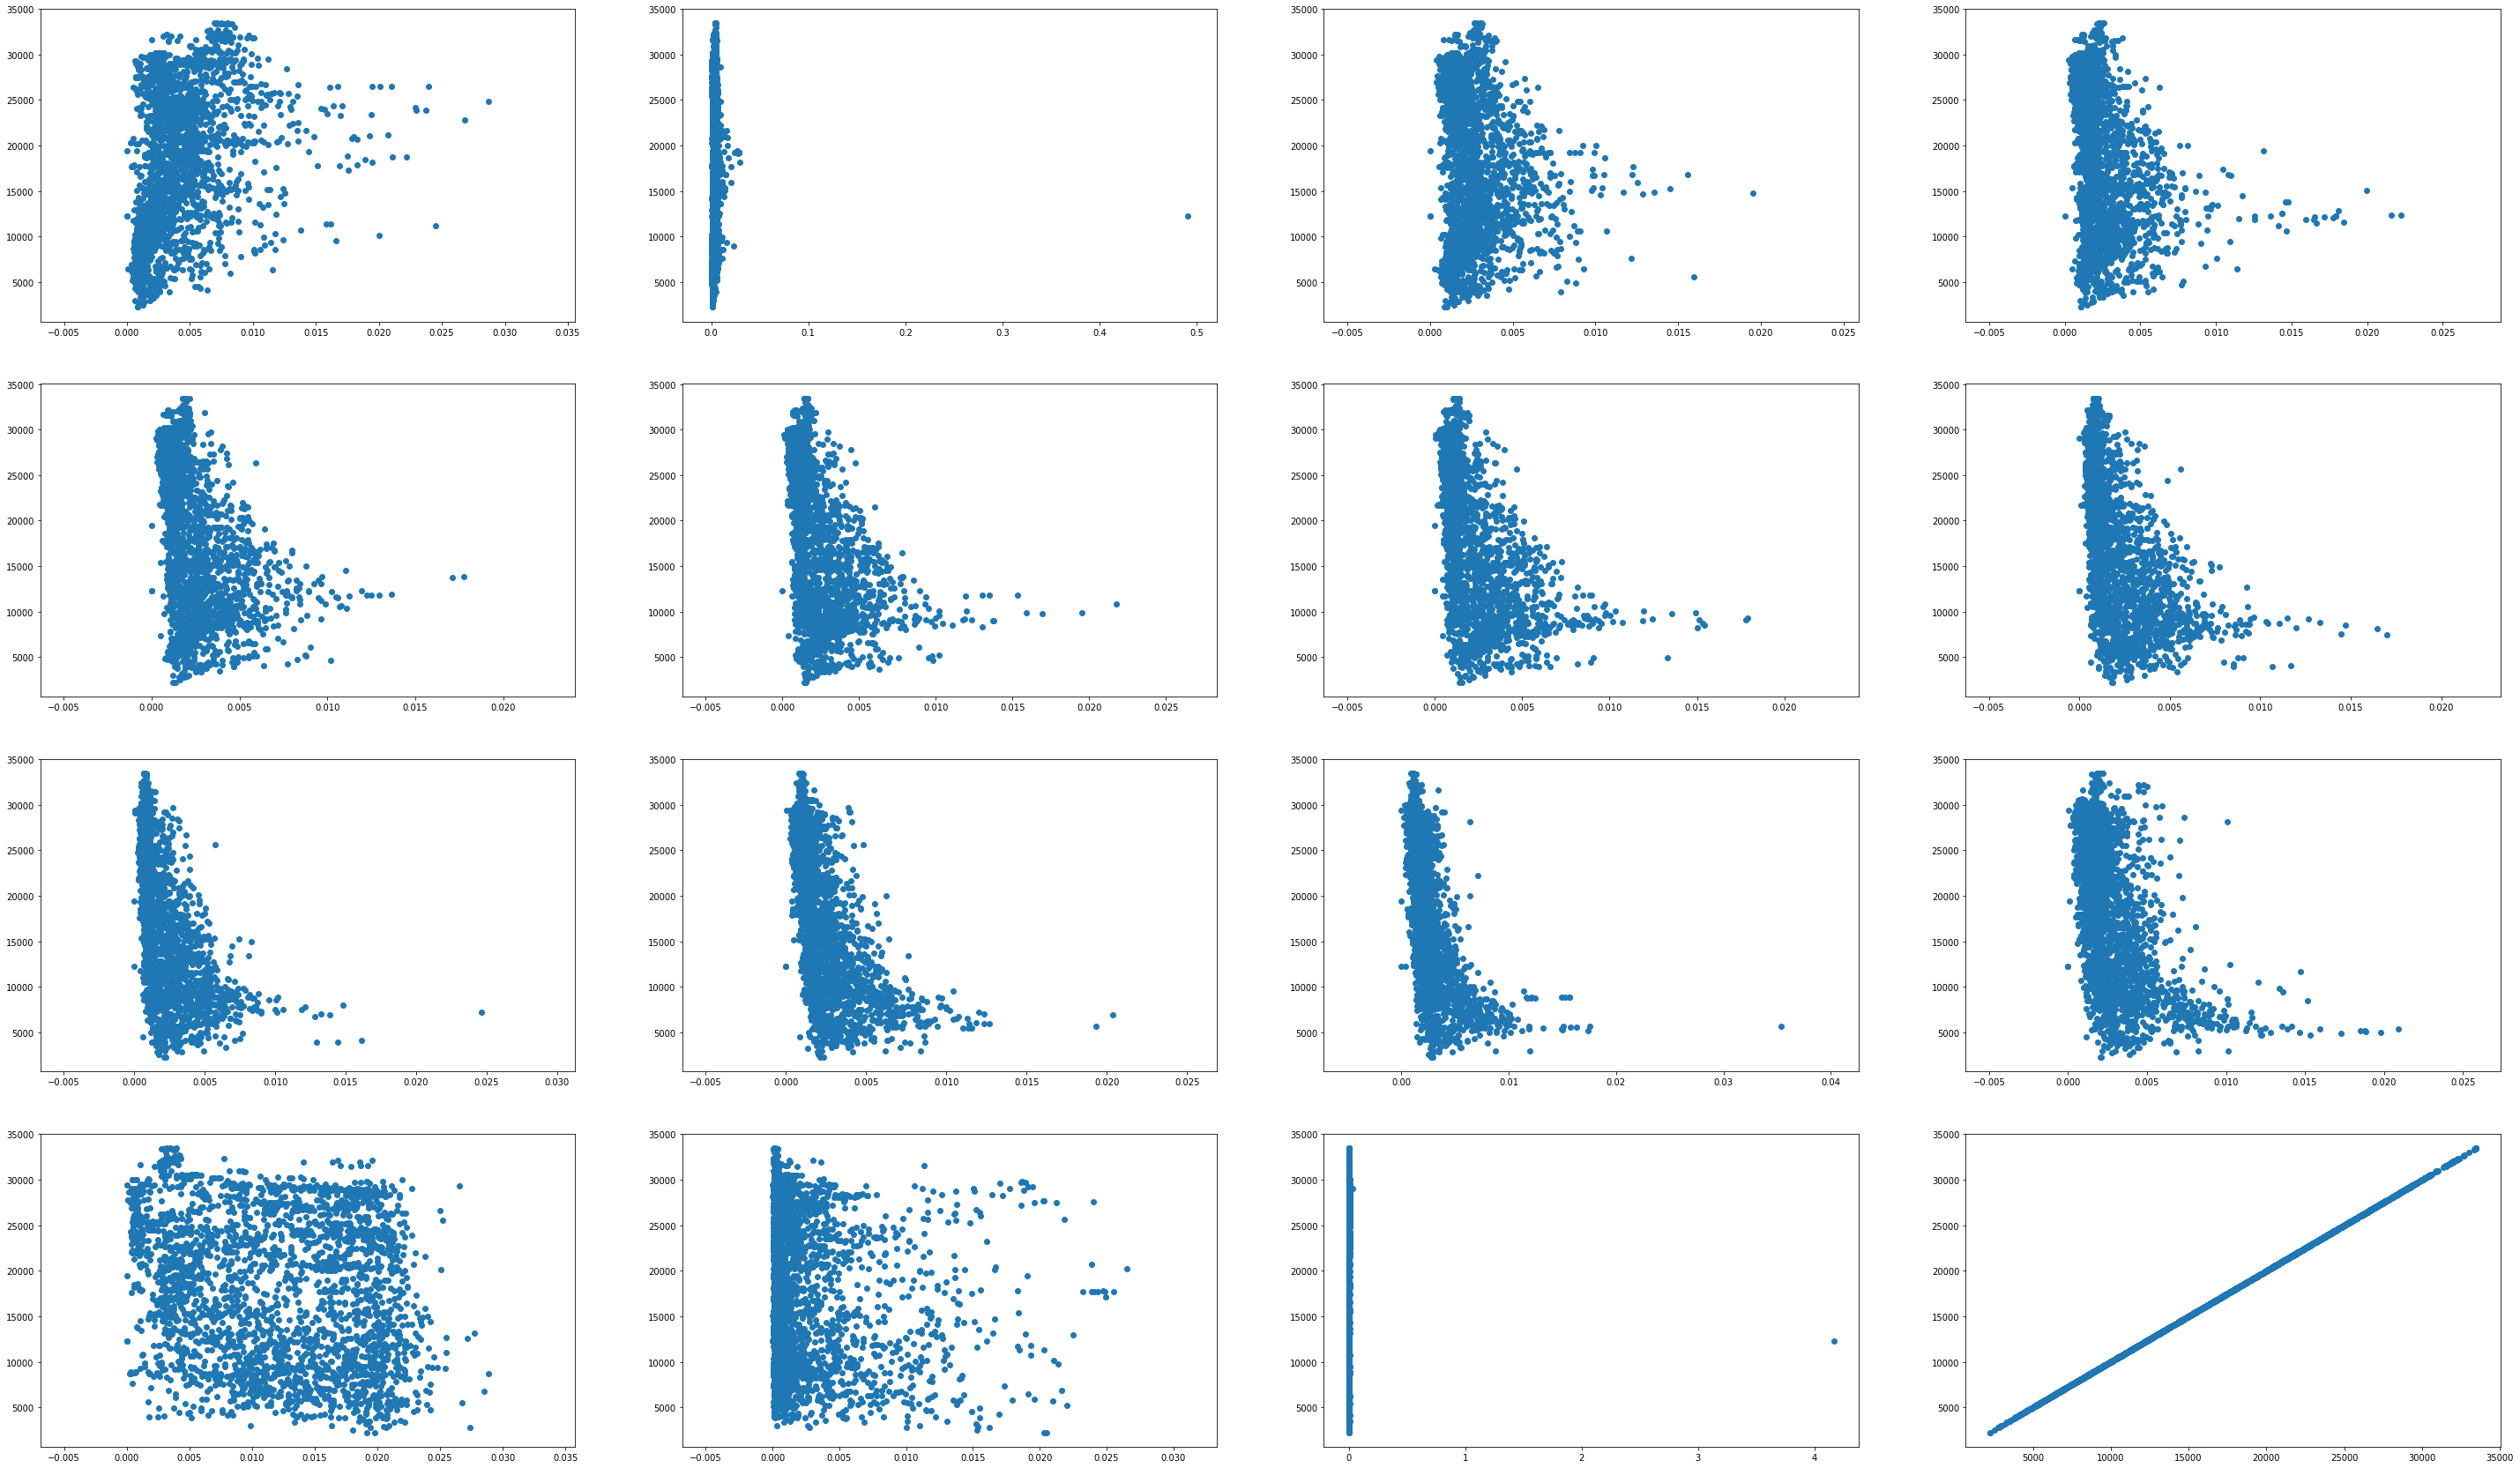

In [47]:
%matplotlib inline

fig=plt.figure(figsize=(50, 30))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    x = df16[df16.columns[i]]
    y = df16['peso']
    plt.scatter(x, y)
plt.show()


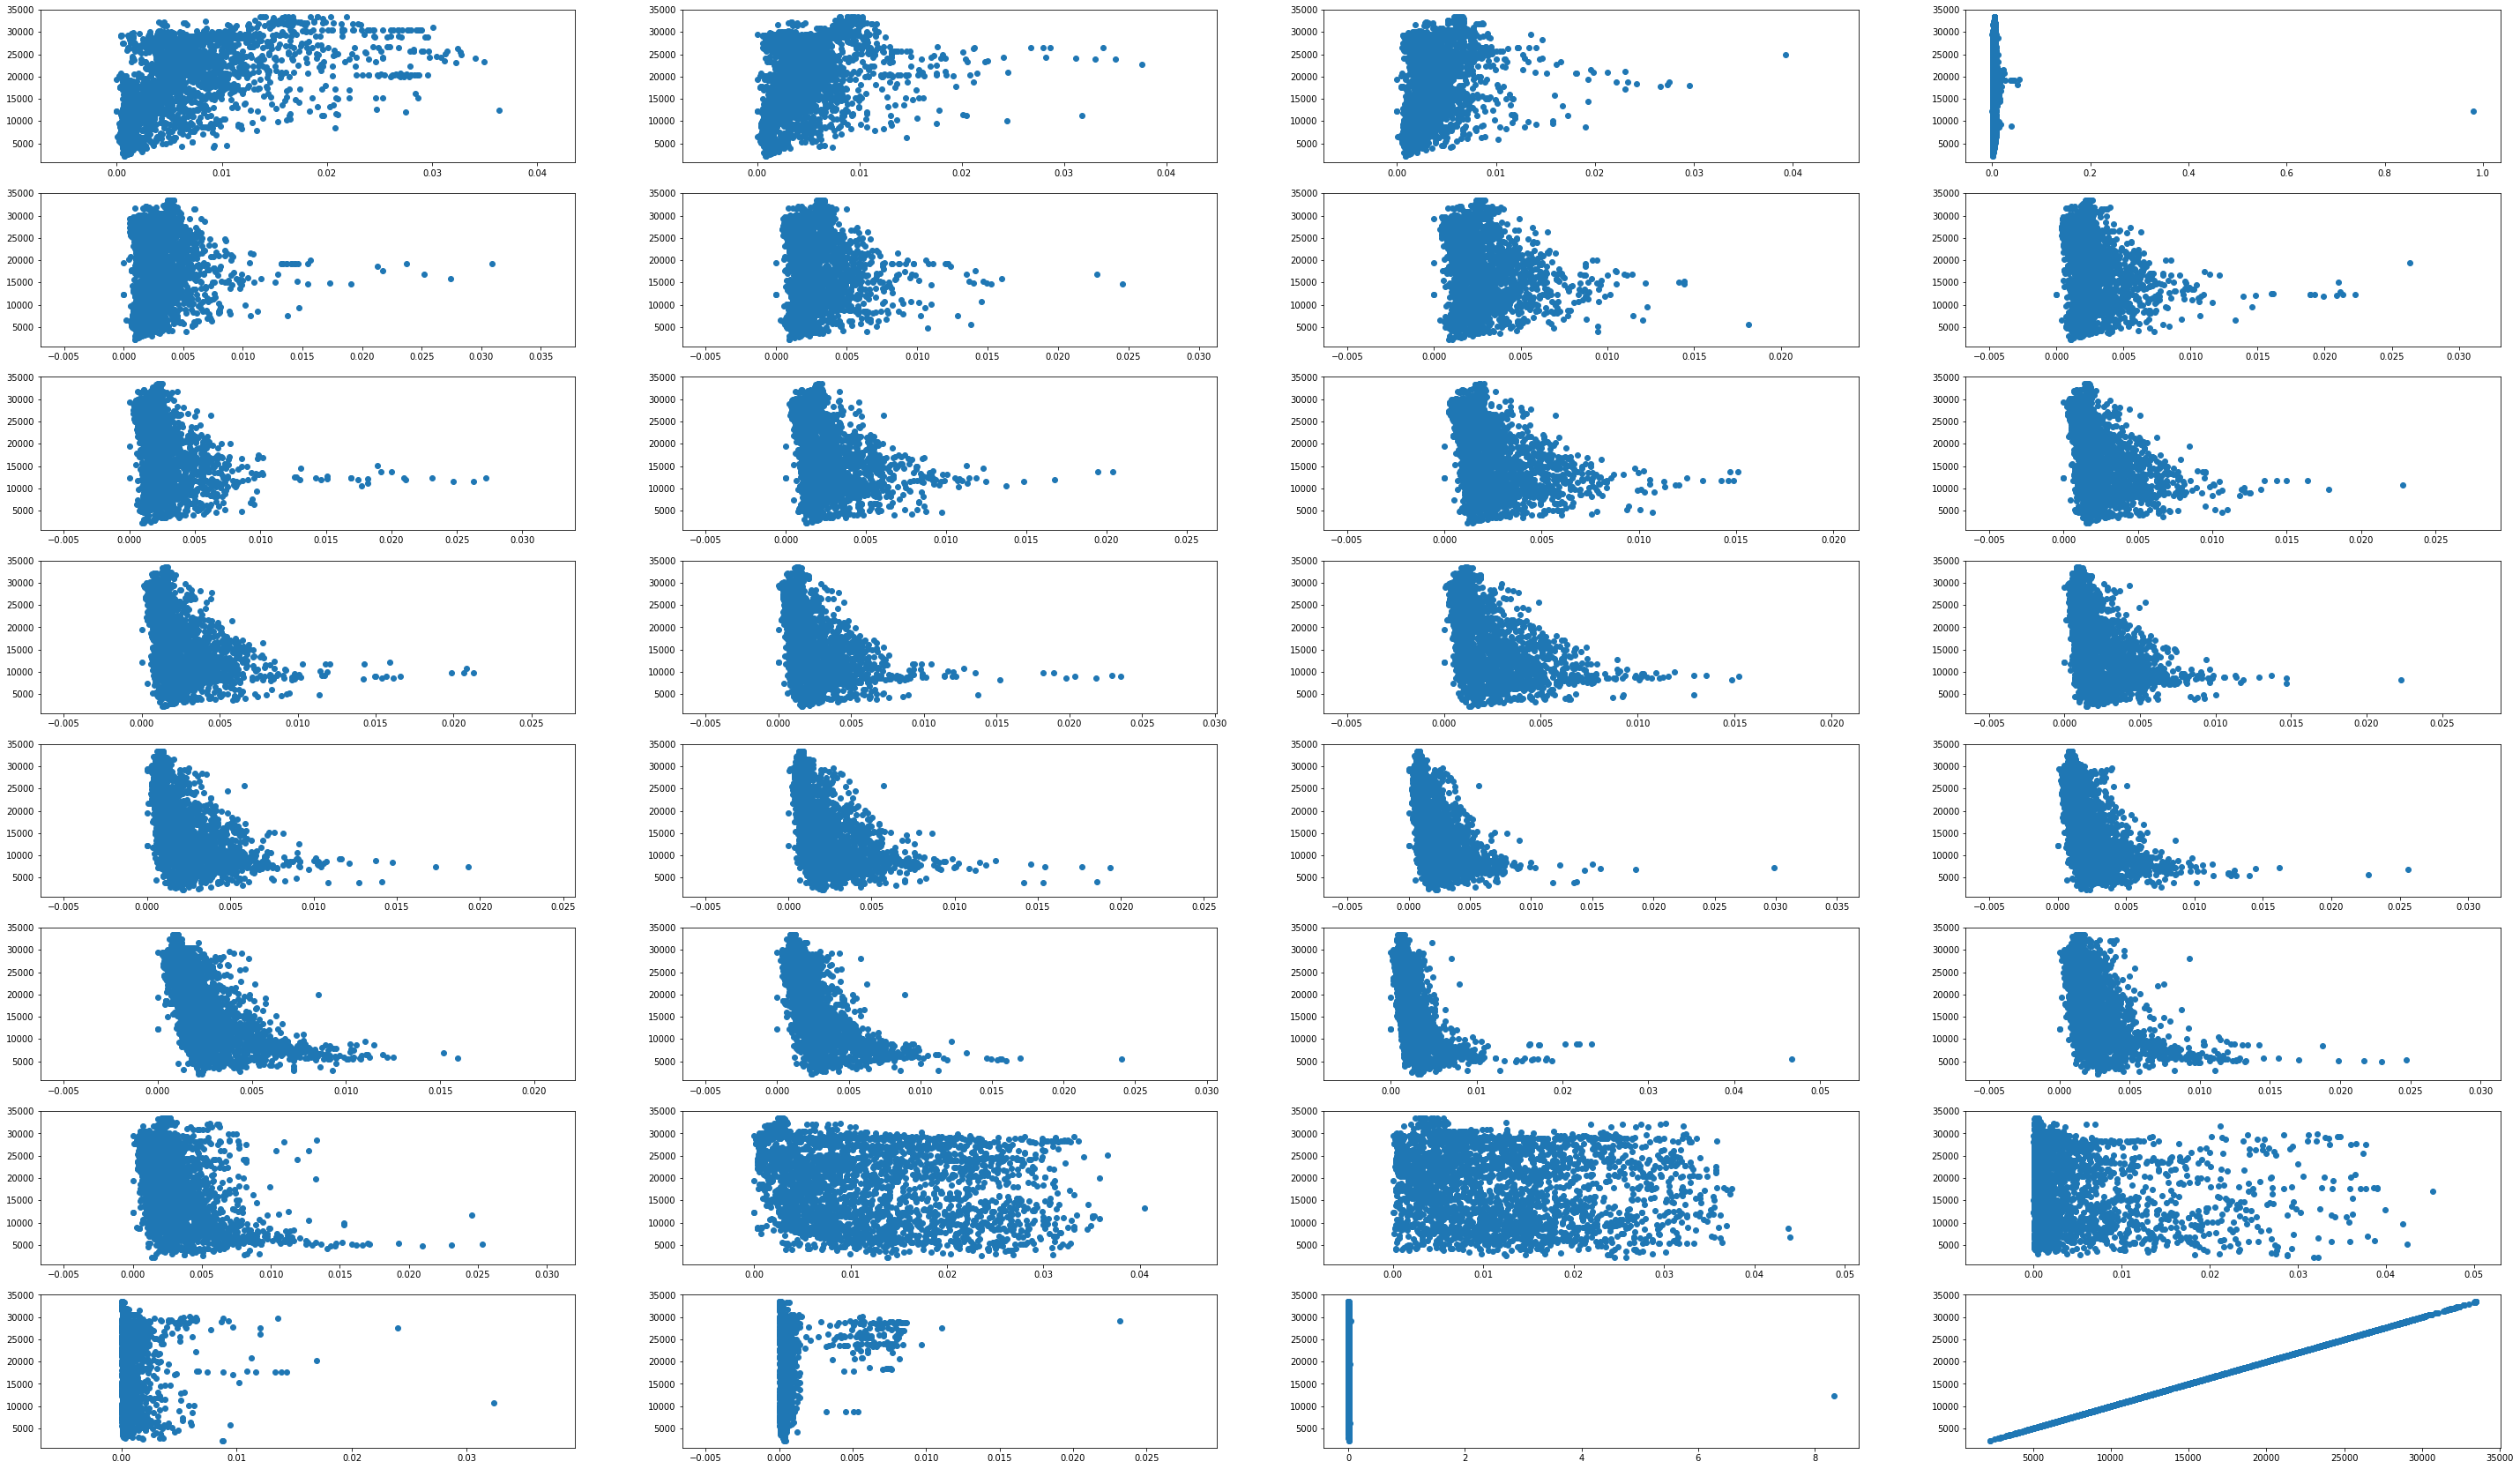

In [48]:
histograms32 = [np.histogram(np.asarray(image[0]), bins=32, density=True)[0] for image in images]
titulo32 = np.histogram(np.asarray(images[0][0]), bins=32, density=True)[1]
df32 = pd.DataFrame(histograms32)
df32.columns = titulo32[1:]
df32['peso'] = pesos

fig=plt.figure(figsize=(50, 30))
columns = 4
rows = 8

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    x = df32[df32.columns[i]]
    y = df32['peso']
    plt.scatter(x, y)
plt.show()

In [78]:
def histogram_param(bins):
    histograms = [np.histogram(np.asarray(image[0]), bins=bins)[0] for image in images]
    titulo = np.histogram(np.asarray(images[0][0]), bins=bins)[1]
    df = pd.DataFrame(histograms)
    df.columns = titulo[1:]
    df['peso'] = pesos

    fig=plt.figure(figsize=(50, 30))
    columns = 4
    rows = bins // columns

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        x = df[df.columns[i - 1]]
        y = df['peso']
        plt.scatter(x, y)
    plt.show()

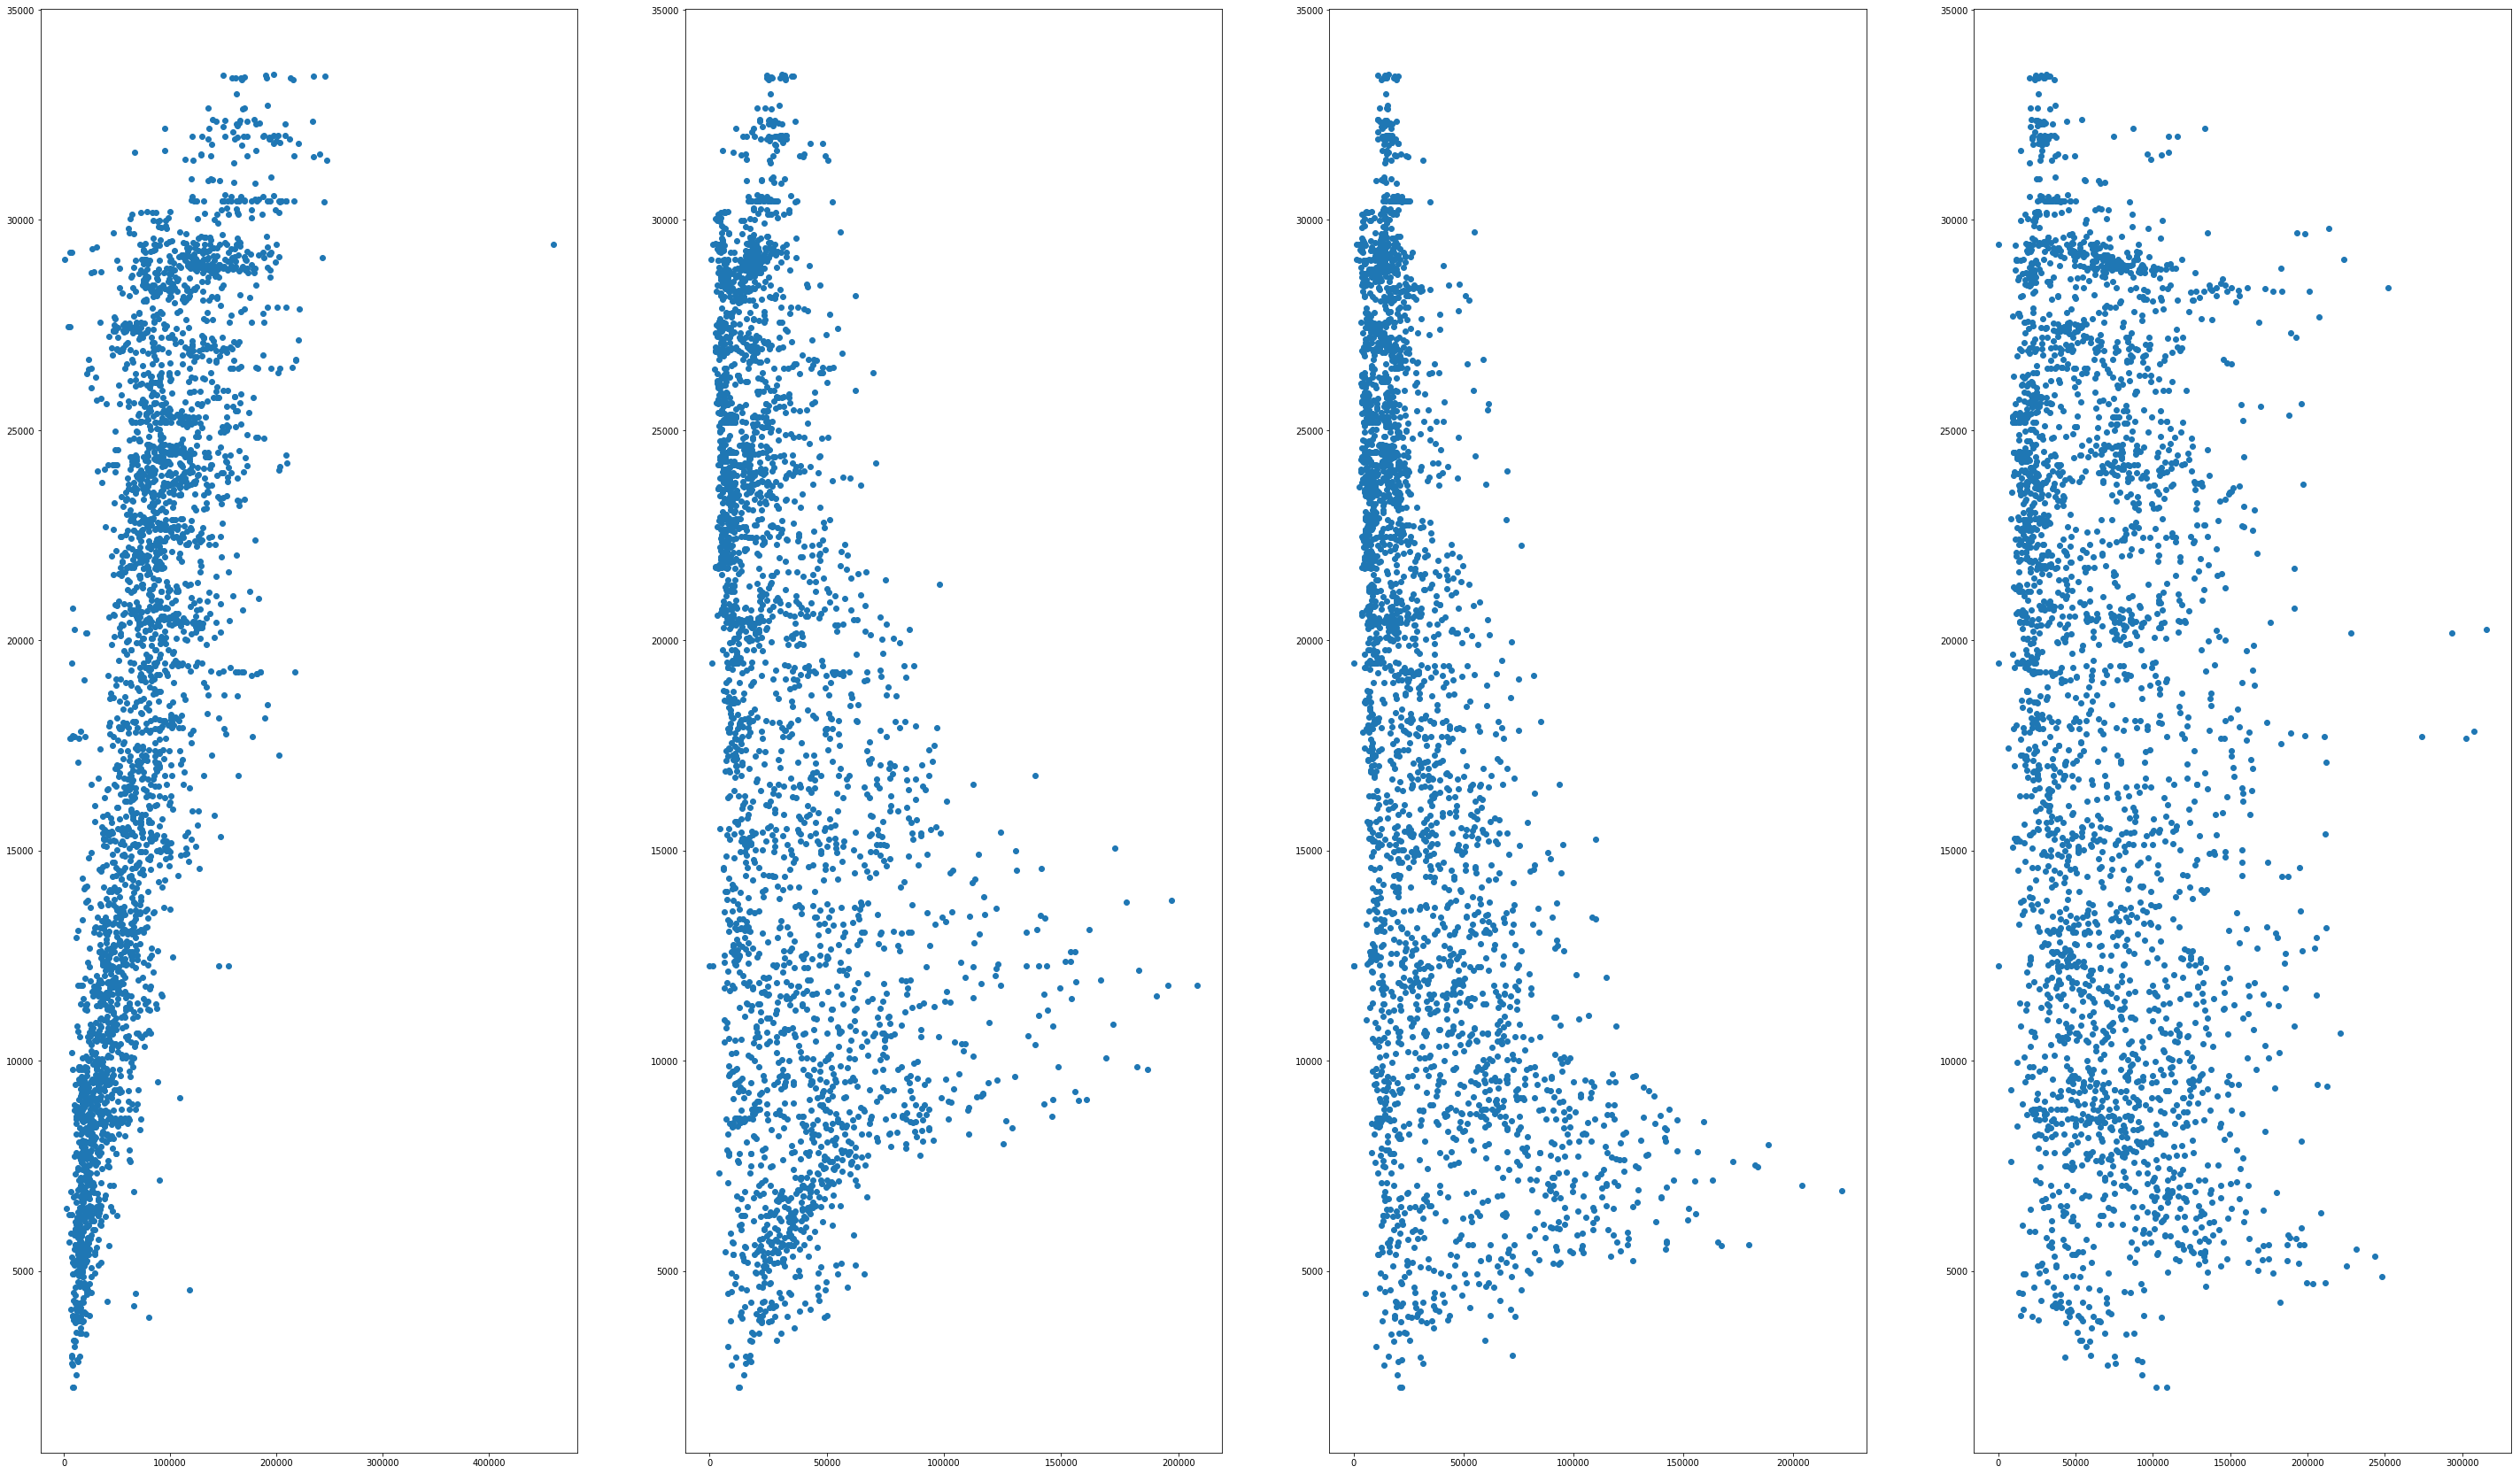

In [79]:
histogram_param(4)

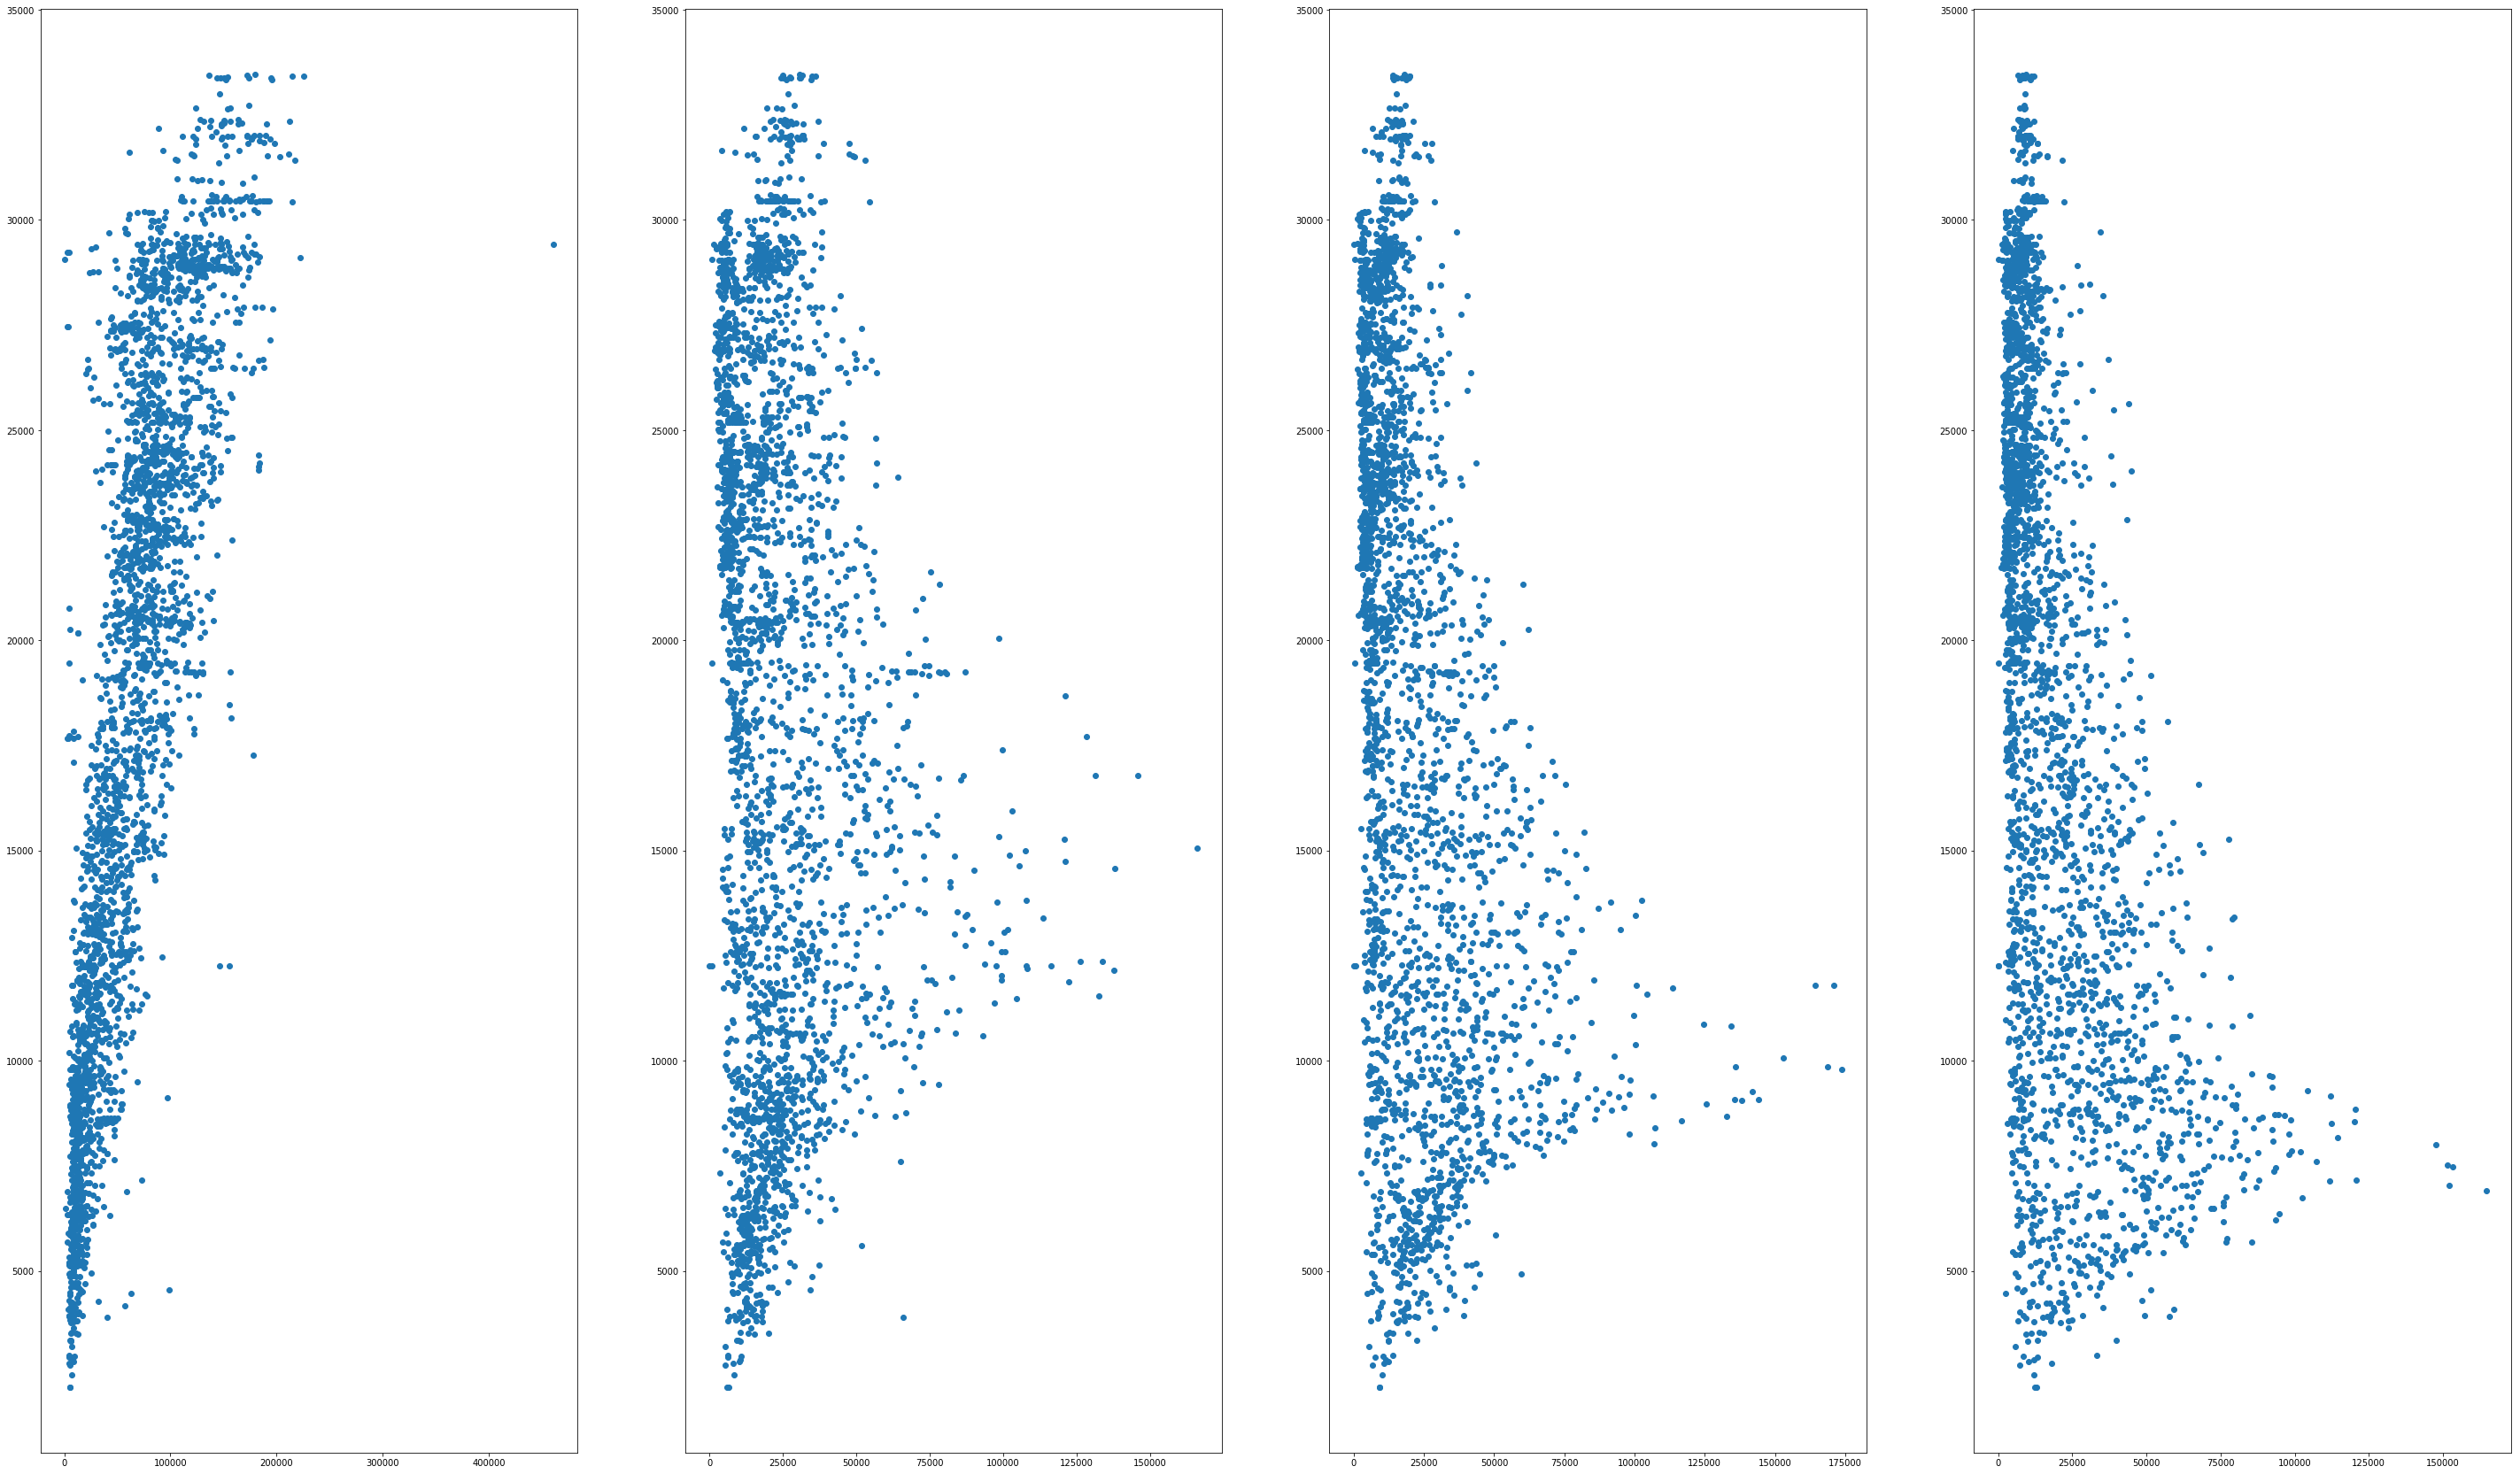

In [80]:
histogram_param(6)

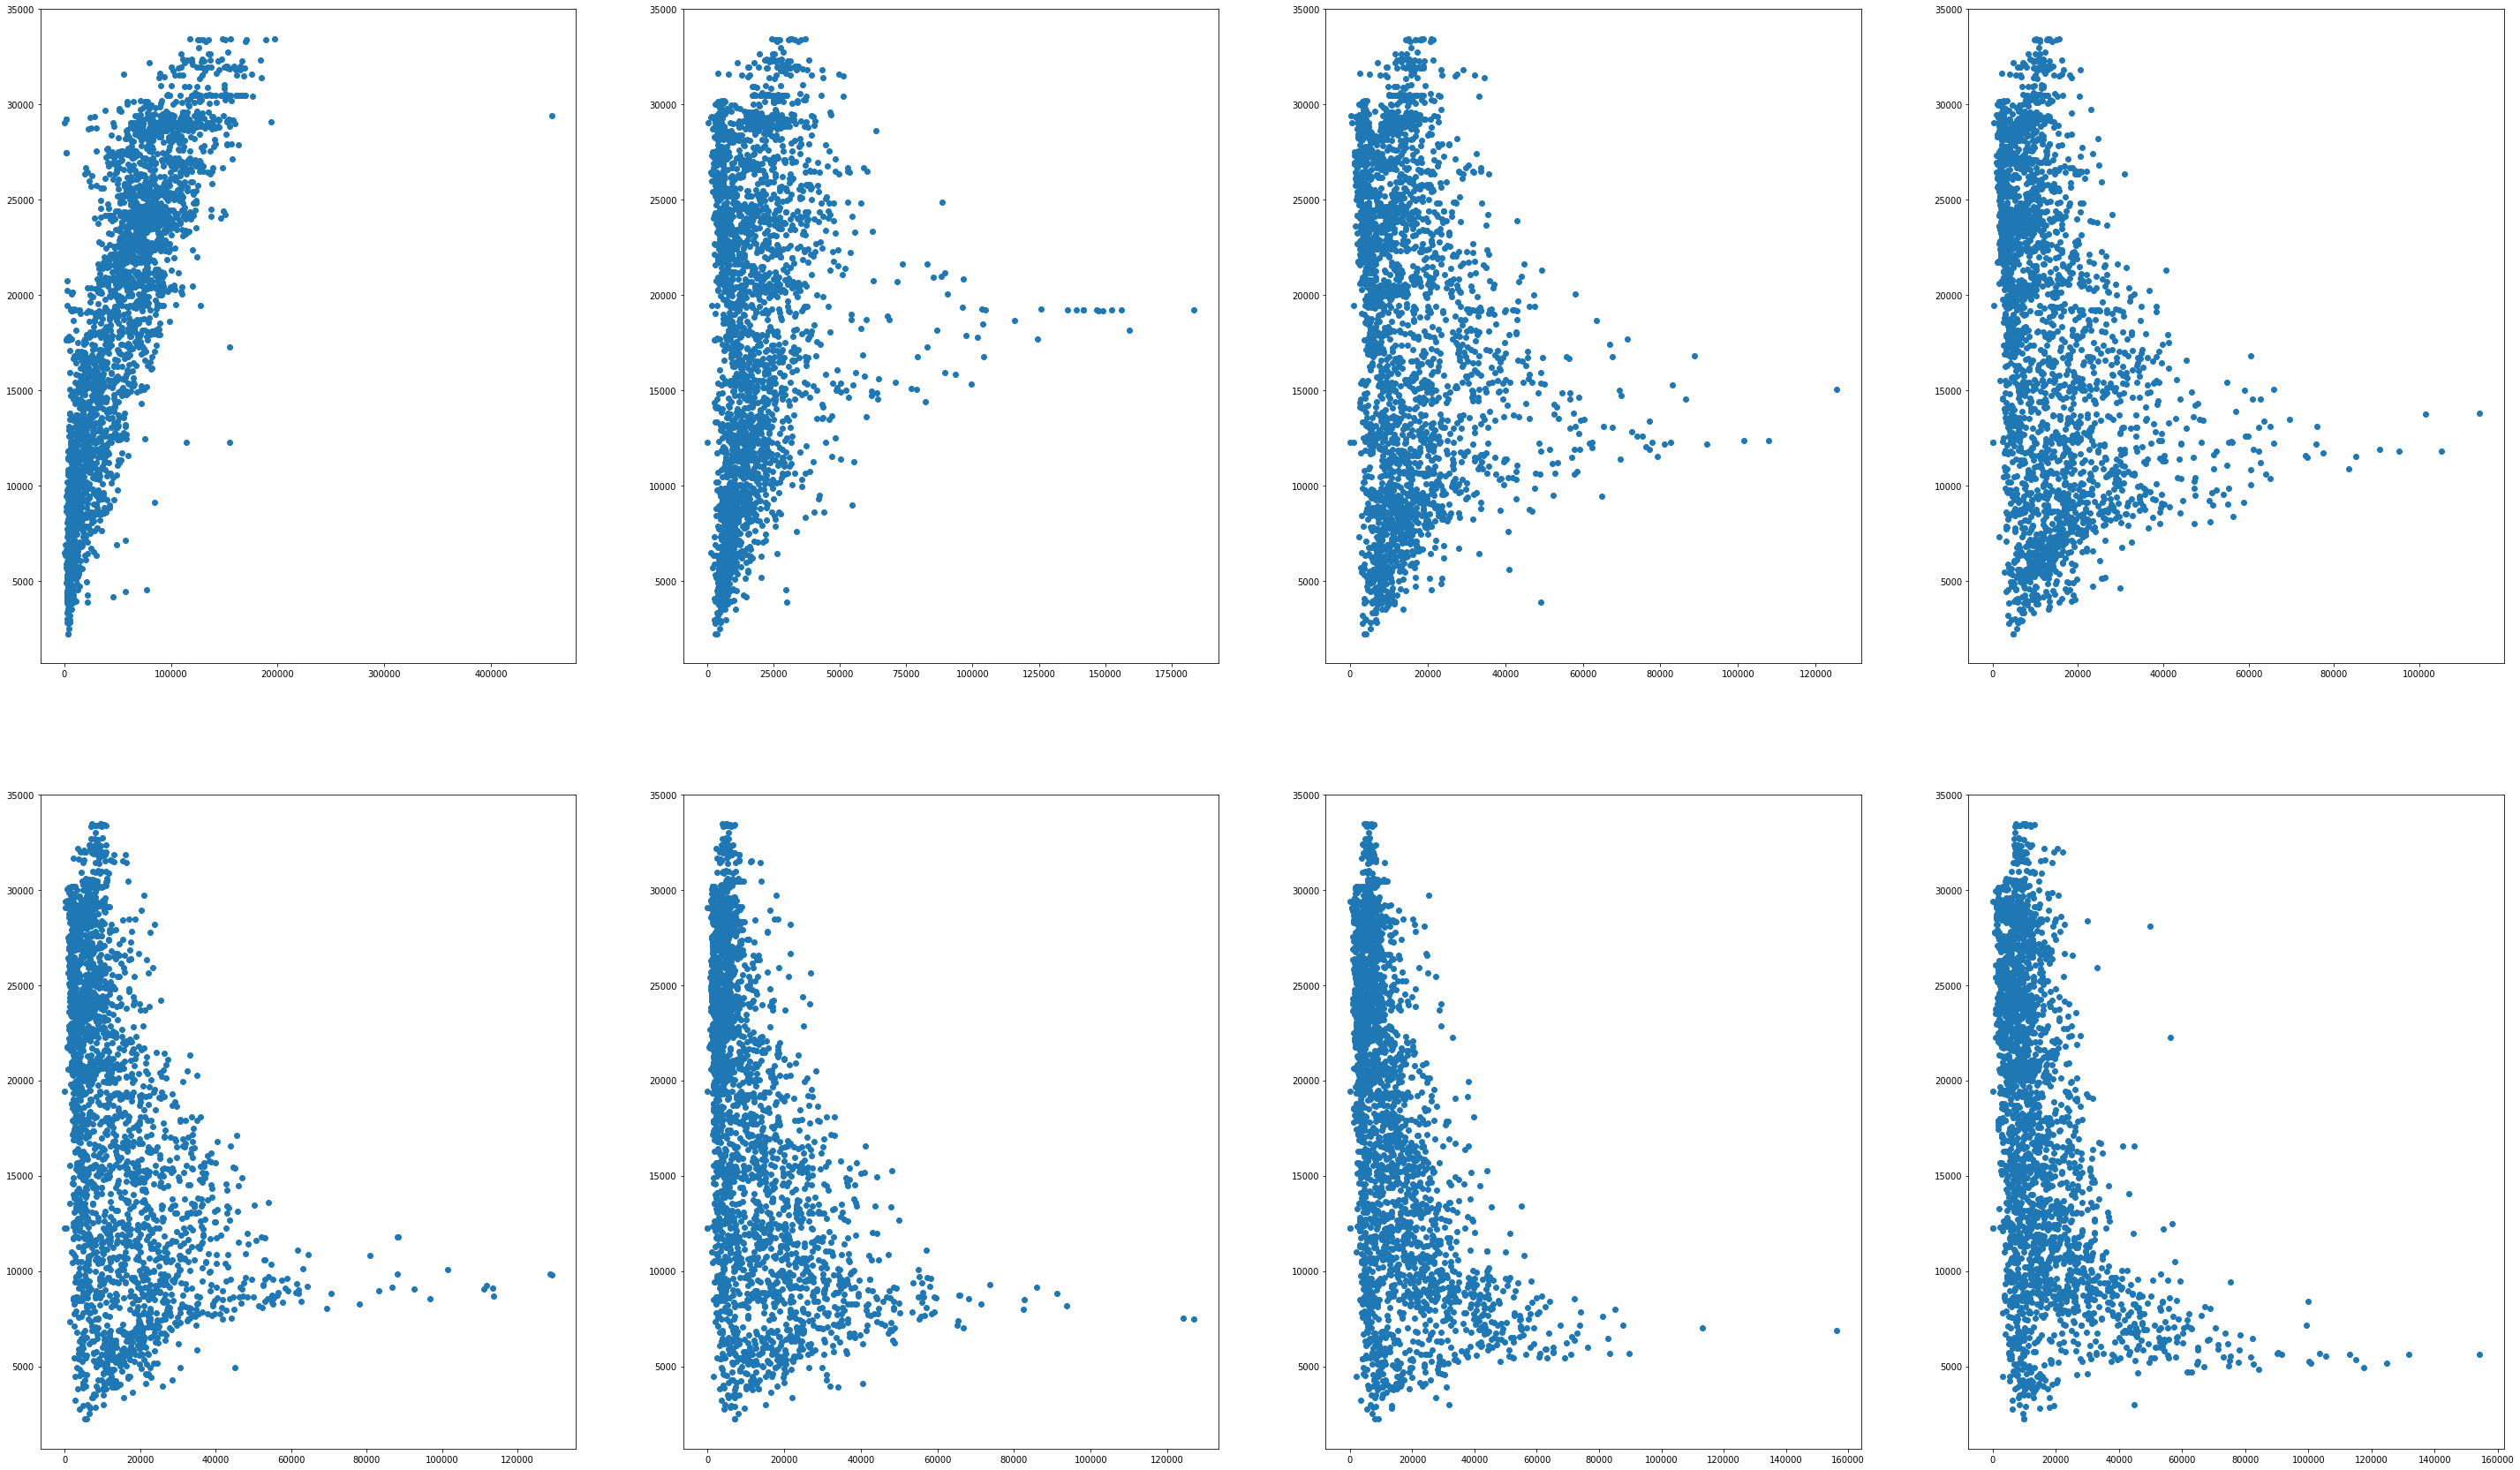

In [81]:
histogram_param(10)

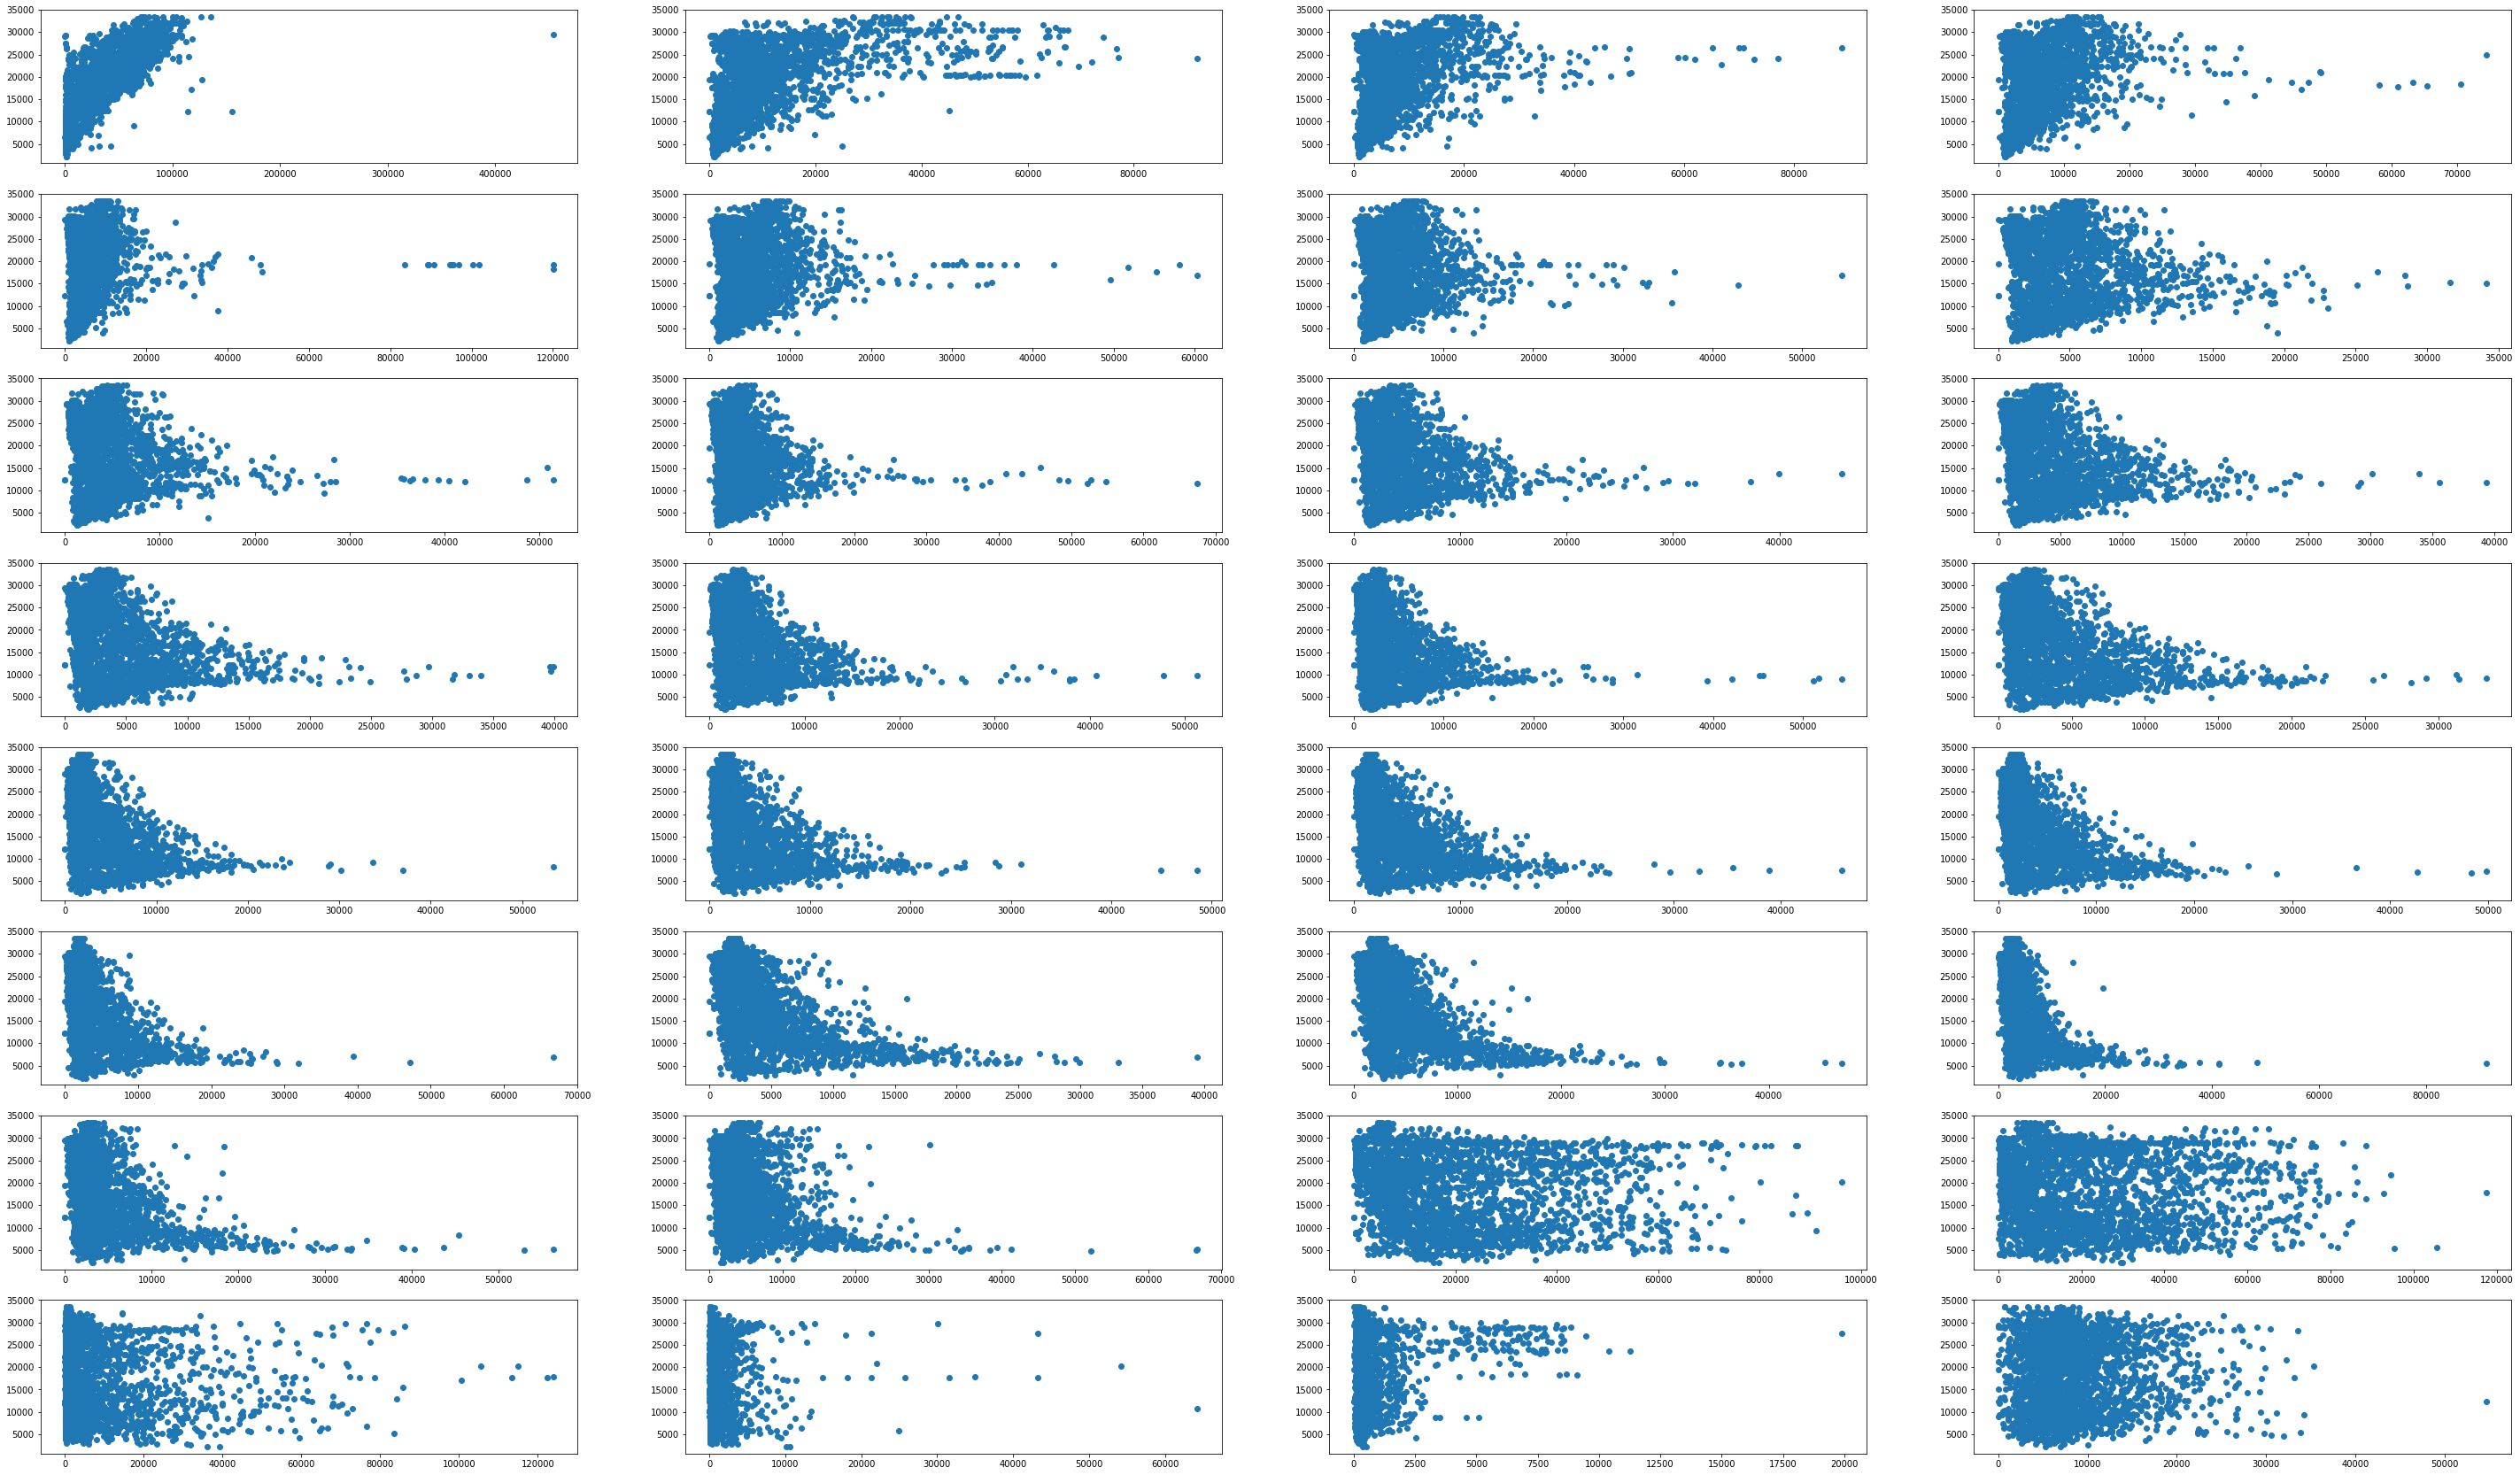

In [82]:
histogram_param(32)

In [146]:
from sklearn.decomposition import PCA

histograms = [np.histogram(np.asarray(image[0]), bins=42)[0] for image in images]
titulo = np.histogram(np.asarray(images[0][0]), bins=42)[1]

In [147]:
pca = PCA(n_components=4)
pca.fit(histograms)

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)

[0.45573086 0.19348269 0.08414772 0.07273575]
[1716513.93585981 1118443.81852964  737588.78113947  685751.99634561]


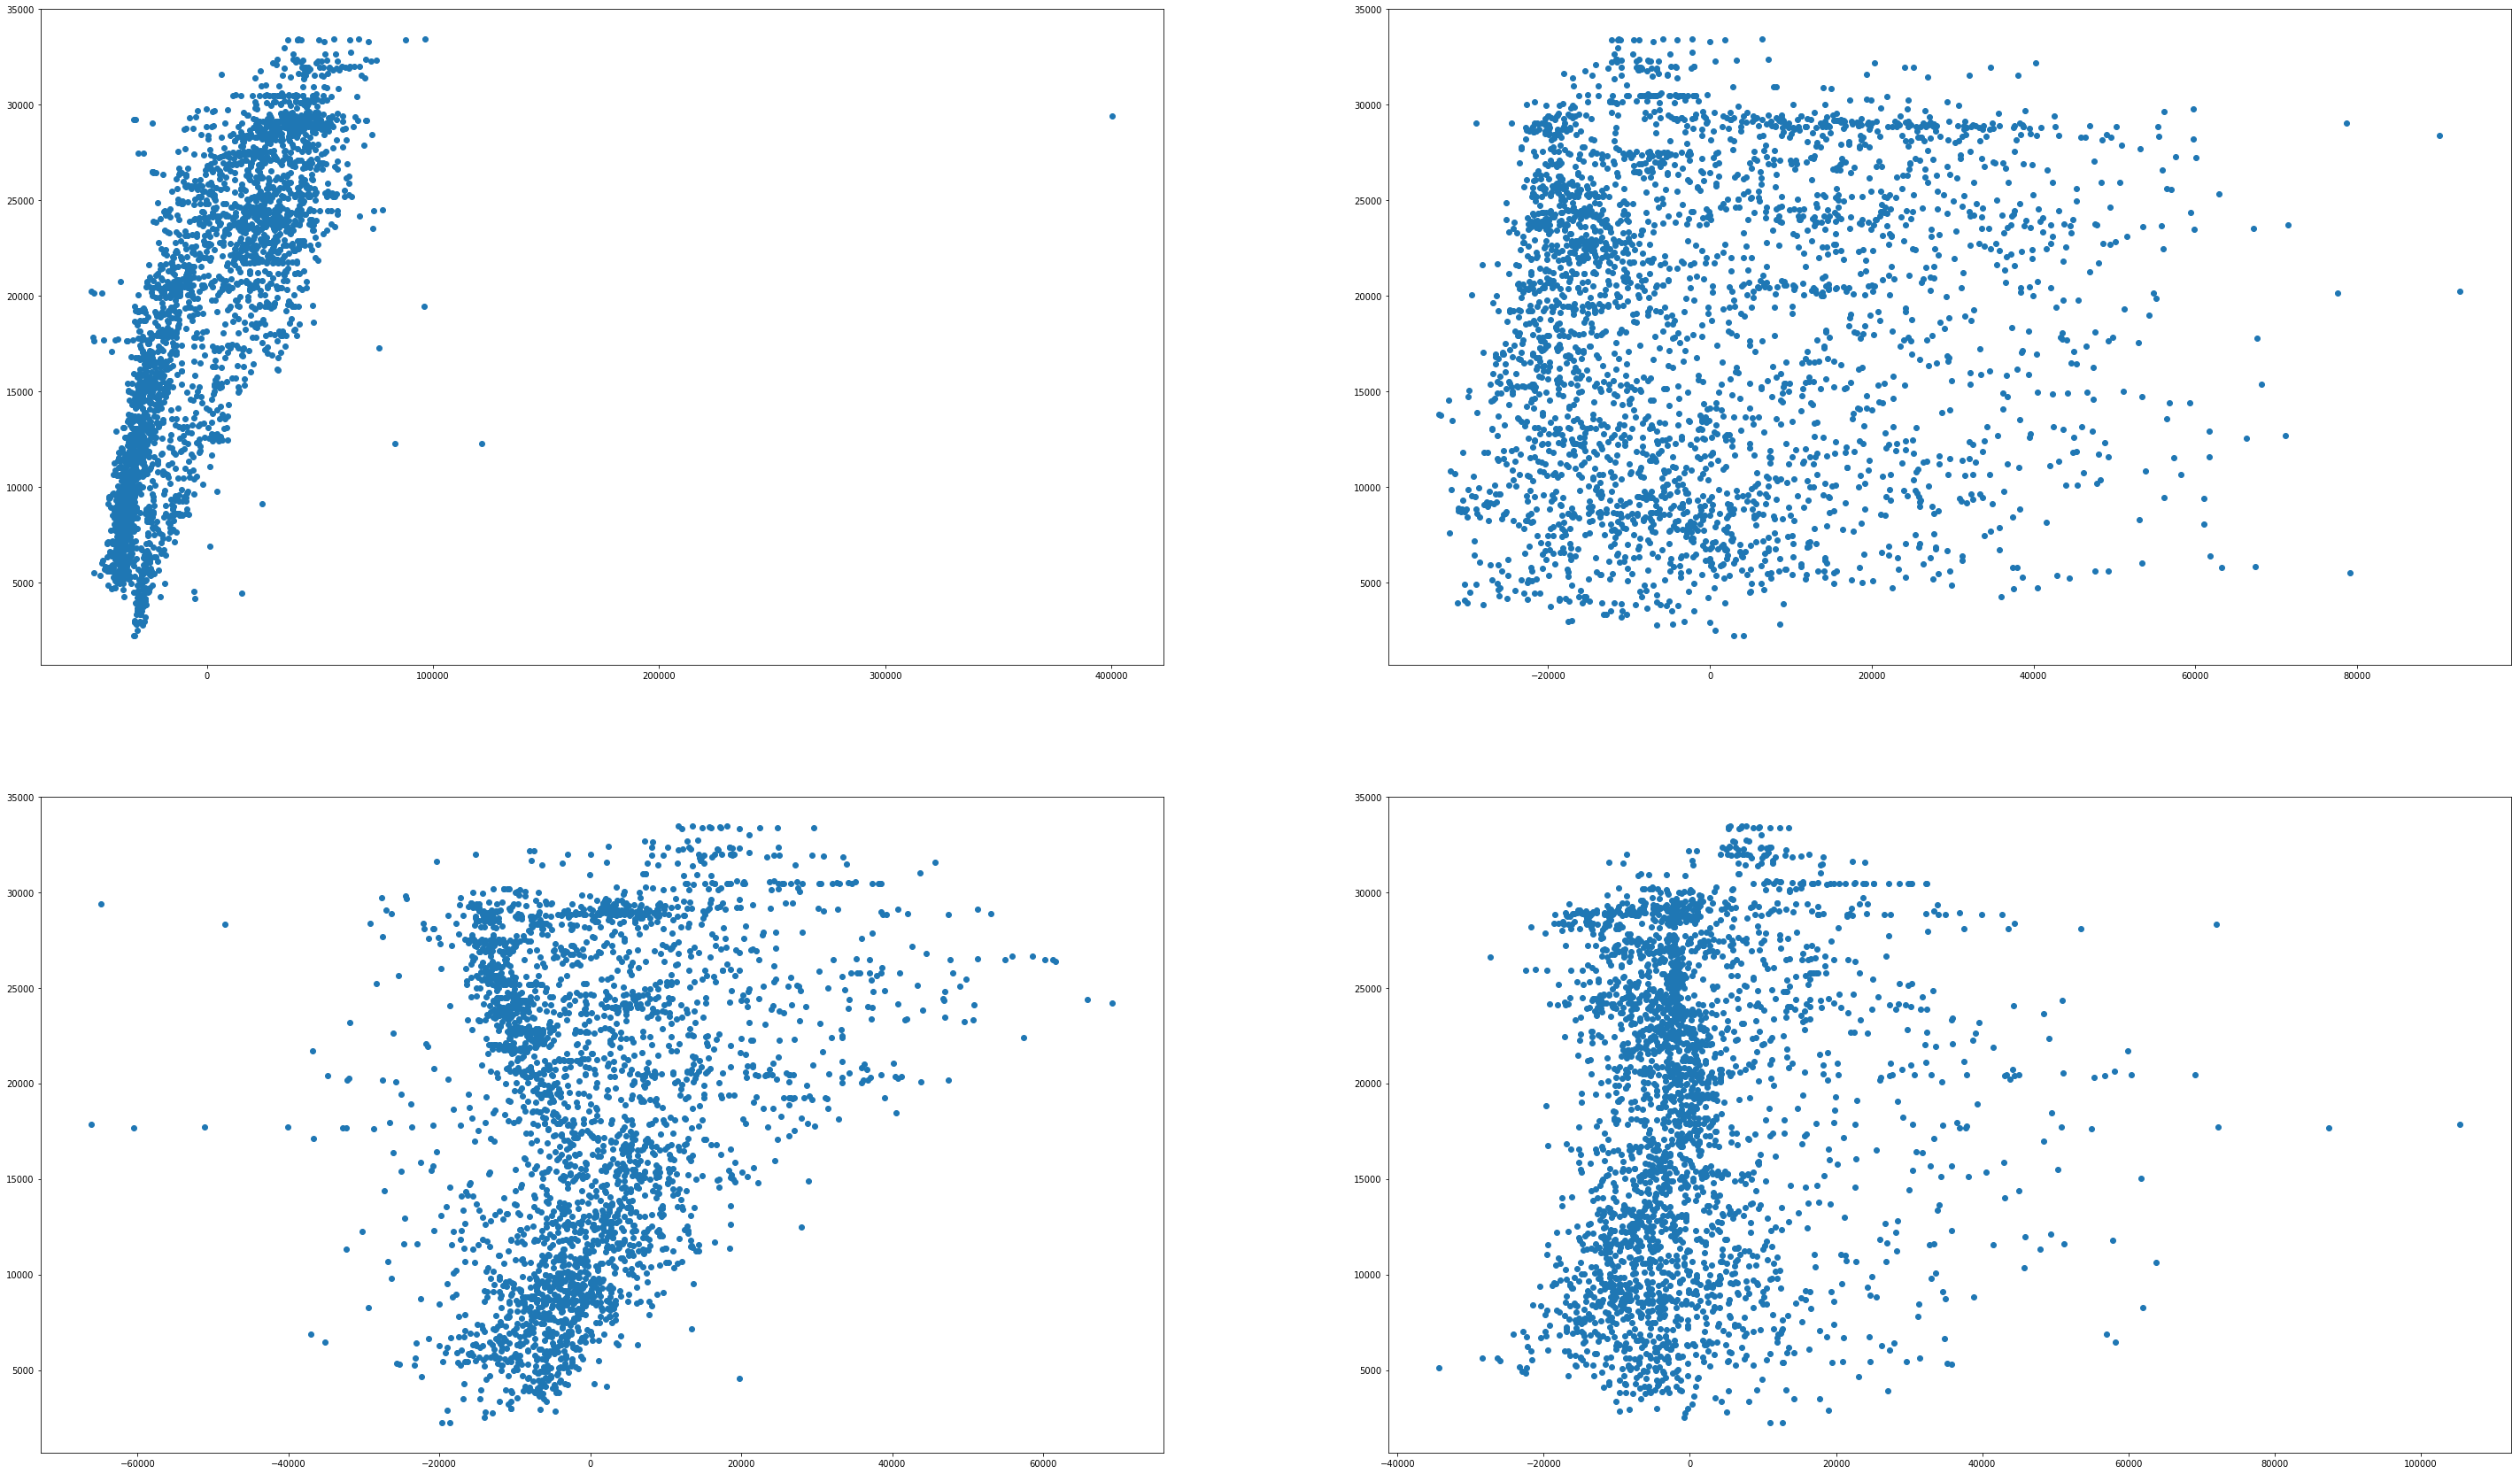

In [148]:
X = pca.transform(histograms)

dfpca = pd.DataFrame(X)
y = pesos

fig=plt.figure(figsize=(50, 30))
columns = 2

rows = 2
for i in range(1, 5):
    fig.add_subplot(rows, columns, i)
    x = dfpca[dfpca.columns[i - 1]]
    plt.scatter(x, y)
plt.show()

In [149]:
for i in range(4):
    print(i, np.corrcoef(dfpca[dfpca.columns[i]], y))

0 [[1.         0.80727596]
 [0.80727596 1.        ]]
1 [[1.         0.09045211]
 [0.09045211 1.        ]]
2 [[1.        0.2288693]
 [0.2288693 1.       ]]
3 [[1.         0.12189336]
 [0.12189336 1.        ]]


In [150]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, \
    mean_absolute_error, median_absolute_error 

def regression_plot(X, y):
    X_train = X[:-500]
    X_test = X[-500:]

    y_train = y[:-500]
    y_test = y[-500:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test, y_pred))
    print("Mean absolute error: %.2f"
          % mean_absolute_error(y_test, y_pred))
    print("Median absolute error: %.2f"
          % median_absolute_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

    # Plot outputs
    plt.scatter(y_test, y_test,  color='black')
    plt.scatter(y_test, y_pred, color='blue', linewidth=3)

    plt.xticks(())
    plt.yticks(())

    plt.show()

Coefficients: 
 [0.2010269  0.02647663 0.1396241  0.07987609]
Mean squared error: 23977517.25
Mean absolute error: 3848.96
Median absolute error: 3228.32
Variance score: 0.65


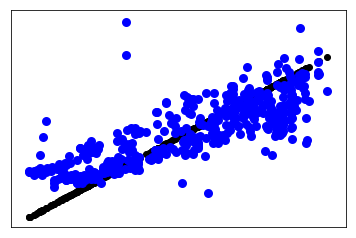

In [151]:
regression_plot(X, pesos)

Coefficients: 
 [    3134.96851272  -173206.33701592  -704164.0172505   -760533.95687081
  -648875.013825   -1488241.12420537  -708545.63918714]
Mean squared error: 38277362.96
Variance score: 0.44


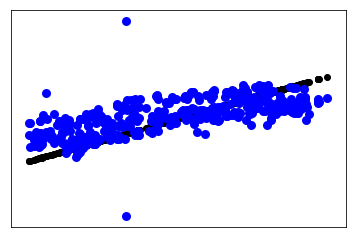

In [106]:
regression_plot(df[df.columns[0:7]], df['peso'])

Coefficients: 
 [ 2.51656637e+02  1.11361851e+05 -1.48285950e+05 -3.50073005e+05
 -3.55098877e+05 -1.60995211e+05 -5.59160091e+05 -2.28656396e+05
 -5.10316580e+05 -2.13727767e+05 -5.84827313e+05 -7.95778764e+05
 -5.02787589e+05 -2.41612472e+05 -3.61594975e+05]
Mean squared error: 40769692.90
Variance score: 0.40


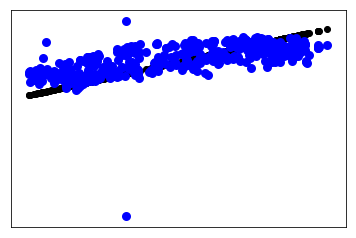

In [100]:
regression_plot(df16[df16.columns[0:15]], df16['peso'])

Coefficients: 
 [    2775.29902311   150684.889741    -149867.03216587   101443.71976505
  -155392.70350587   190534.72929146  -621416.19846616   150345.10276592
  -225611.4684672    -10674.56967144  -657006.61518694   744714.14057628
 -1072813.35272918   539031.91945869  -787663.75644314   213300.51365964
  -355299.81374475   337981.94969796 -1276776.03252585   663345.31988585
   -81538.8130176   -973958.27473544    12894.68060612  -539131.87627903
   -85184.07808861  -303030.7225413   -166196.86671752   -56147.53395599
  -224880.35308535    39093.37217994  -263647.08623707]
Mean squared error: 74222718.45
Variance score: -0.09


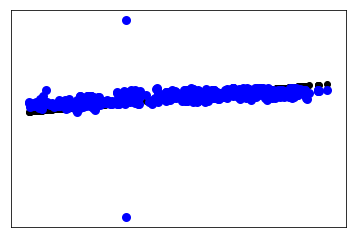

In [101]:
regression_plot(df32[df32.columns[0:31]], df32['peso'])

In [174]:
X = [np.asarray(image[0]).sum() for image in images]
np.corrcoef(X, y)

array([[ 1.        , -0.45375061],
       [-0.45375061,  1.        ]])

In [179]:
X = np.array(X)
X = X[:, np.newaxis]
X

array([[39495645],
       [27030156],
       [22050180],
       ...,
       [12337248],
       [ 6156972],
       [19327545]], dtype=uint64)

Coefficients: 
 [-0.00029308]
Mean squared error: 67007743.02
Mean absolute error: 6711.77
Median absolute error: 5749.65
Variance score: 0.01


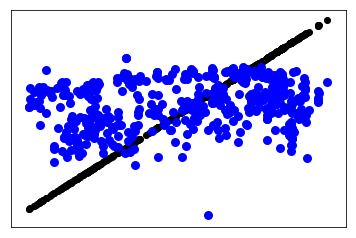

In [180]:
regression_plot(X, y)

In [167]:
df_combinado = df_pca


array([[ 0.06169621],
       [-0.05147406],
       [ 0.04445121],
       [-0.01159501],
       [-0.03638469],
       [-0.04069594],
       [-0.04716281],
       [-0.00189471],
       [ 0.06169621],
       [ 0.03906215],
       [-0.08380842],
       [ 0.01750591],
       [-0.02884001],
       [-0.00189471],
       [-0.02560657],
       [-0.01806189],
       [ 0.04229559],
       [ 0.01211685],
       [-0.0105172 ],
       [-0.01806189],
       [-0.05686312],
       [-0.02237314],
       [-0.00405033],
       [ 0.06061839],
       [ 0.03582872],
       [-0.01267283],
       [-0.07734155],
       [ 0.05954058],
       [-0.02129532],
       [-0.00620595],
       [ 0.04445121],
       [-0.06548562],
       [ 0.12528712],
       [-0.05039625],
       [-0.06332999],
       [-0.03099563],
       [ 0.02289497],
       [ 0.01103904],
       [ 0.07139652],
       [ 0.01427248],
       [-0.00836158],
       [-0.06764124],
       [-0.0105172 ],
       [-0.02345095],
       [ 0.06816308],
       [-0